In [2]:
import numpy as np
import rasterio
import ee
import fiona
import rasterio.mask
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


ee.Initialize()

In [3]:
from matplotlib.pyplot import figure

def gera_data(link_shp, link_tiff):
    with fiona.open(link_shp) as shape_afetadas:
        afetadas = [feature["geometry"] for feature in shape_afetadas]

    with rasterio.open(link_tiff) as regress:
        afetadas_regress, out_transform = rasterio.mask.mask(regress, afetadas, crop=True)
        out_meta = regress.meta

    out_meta.update({"driver": "GTiff",
                     "height": afetadas_regress.shape[1],
                     "width": afetadas_regress.shape[2],
                     "transform": out_transform})

    with rasterio.open("afetadas.tif", "w", **out_meta) as dest:
        dest.write(afetadas_regress)

    df1 = pd.DataFrame(columns=['anomalies'],data=list(zip(afetadas_regress.flatten())))
    remove_index = df1[df1['anomalies']<1].index
    df1 = df1.drop(remove_index)
    maximo = df1.max().values
    
    df1.loc[df1["anomalies"]<int(0.2*maximo),'label'] = "Very low"
    df1.loc[(df1["anomalies"]<int(0.4*maximo)) & (df1["anomalies"]>=int(0.2*maximo)),'label'] = "Low"
    df1.loc[(df1["anomalies"]<int(0.6*maximo)) & (df1["anomalies"]>=int(0.4*maximo)),'label'] = "Medium"
    df1.loc[(df1["anomalies"]<int(0.8*maximo)) & (df1["anomalies"]>=int(0.6*maximo)),'label'] = "High"
    df1.loc[df1["anomalies"]>=int(0.8*maximo),'label'] = "Very high"
    df1.reset_index(inplace=True, drop=True)
    df1.loc[df1['label']=="Very high", 'id'] = 5
    df1.loc[df1['label']=="High", 'id'] = 4
    df1.loc[df1['label']=="Medium", 'id'] = 3
    df1.loc[df1['label']=="Low", 'id'] = 2
    df1.loc[df1['label']=="Very low", 'id'] = 1
    return df1

def histo_gera(df1, df2, year):
    figure(figsize=(14,10), dpi=300)
    titulo = "PRODES Deforestation alerts and NDVI Anomalies for Altamira-PA " + year
    plt.title(titulo, fontsize=25)
    plt.xlabel('Anomaly count', fontsize=25)
    plt.ylabel('Frequency', fontsize=25)
    labels1 = df1.sort_values(by=['id'])['label'].unique()
    t1 = []
    t2 = []
    for label in labels1:
        t1.append(df1.sort_values(by=['id'])['label'].value_counts()[label])

    labels2 = df2.sort_values(by=['id'])['label'].unique()
    for label in labels2:
        t2.append(df2.sort_values(by=['id'])['label'].value_counts()[label])

    yy = t1/np.sum(t1)
    y2 = t2/np.sum(t2)
    xx = np.arange(len(labels1))
    x2 = np.arange(len(labels2))
    width = 0.35
    ax = plt.subplot(111)
    ax.bar(x2 + width/2, y2, width, color='#07051b', label='One-Class SVM')
    ax.bar(xx - width/2, yy, width, color='#e25734', label='Isolation Forest')
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    ax.set_xticks(xx)
    ax.set_xticklabels(labels1)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=15)
    ax.legend()
    plt.legend(fontsize=20)
    path = "../../Altamira/" + titulo
    plt.savefig(path)
    return 'ok' + titulo

## Group Validation

In [4]:
import os
path = "../../../qgis/Altamira/Area Menor/V2/"
inter_anos = []
dict_shp_path = {}
for x in os.listdir(path):
    if x.endswith(".shp"):
        ano = x[6:-4]
        inter_anos.append(ano)
        dict_shp_path[ano] = path + x
        
dict_shp_path

{'2010-2012': '../../../qgis/Altamira/Area Menor/V2/prodes2010-2012.shp',
 '2010-2015': '../../../qgis/Altamira/Area Menor/V2/prodes2010-2015.shp',
 '2010-2018': '../../../qgis/Altamira/Area Menor/V2/prodes2010-2018.shp',
 '2010-2021': '../../../qgis/Altamira/Area Menor/V2/prodes2010-2021.shp'}

In [7]:
chavinho = inter_anos

In [8]:
dict_tif_path = {}
cont = 0
path = "../../Altamira/Tiff/V3/"
dict_nu = {}
for x in os.listdir(path):
    if x.endswith(".tif"):
        ano = x[-13:-4]
        nuu = x[10:-14]
        if ano in chavinho:
            dict_tif_path[ano] = path + x
            dict_nu[nuu] = dict_tif_path

dict_nu

{'nu_0.025': {'2010-2012': '../../Altamira/Tiff/V3/Alt_OCSVM_nu_0.1_2010-2012.tif'},
 'nu_0.05': {'2010-2012': '../../Altamira/Tiff/V3/Alt_OCSVM_nu_0.1_2010-2012.tif'},
 'nu_0.1': {'2010-2012': '../../Altamira/Tiff/V3/Alt_OCSVM_nu_0.1_2010-2012.tif'}}

In [9]:
dict_tif_path = {}
cont = 0
path = "../../Altamira/Tiff/V3/Valida/"
list_nu = []
for x in os.listdir(path):
    if x.endswith(".tif"):
        list_nu.append(x)
        
list_nu

['Alt_OCSVM_nu_0.025_2010-2012.tif',
 'Alt_OCSVM_nu_0.025_2013-2015.tif',
 'Alt_OCSVM_nu_0.025_2016-2018.tif',
 'Alt_OCSVM_nu_0.025_2019-2021.tif',
 'Alt_OCSVM_nu_0.05_2010-2012.tif',
 'Alt_OCSVM_nu_0.05_2013-2015.tif',
 'Alt_OCSVM_nu_0.05_2016-2018.tif',
 'Alt_OCSVM_nu_0.05_2019-2021.tif',
 'Alt_OCSVM_nu_0.1_2010-2012.tif',
 'Alt_OCSVM_nu_0.1_2013-2015.tif',
 'Alt_OCSVM_nu_0.1_2016-2018.tif',
 'Alt_OCSVM_nu_0.1_2019-2021.tif']

In [11]:
nus = list(dict_nu.keys())
cont=0
dict_nu2 = {}
dict_tif_path = {}
for i in nus:
    dict_tif_path = {}
    for x in list_nu[cont:cont+4]:
        ano = x[-13:-4]
        dict_tif_path[ano] = path + x
        dict_nu2[i] = dict_tif_path
    cont = cont + 4
    
dict_nu2

{'nu_0.025': {'2010-2012': '../../Altamira/Tiff/V3/Valida/Alt_OCSVM_nu_0.025_2010-2012.tif',
  '2013-2015': '../../Altamira/Tiff/V3/Valida/Alt_OCSVM_nu_0.025_2013-2015.tif',
  '2016-2018': '../../Altamira/Tiff/V3/Valida/Alt_OCSVM_nu_0.025_2016-2018.tif',
  '2019-2021': '../../Altamira/Tiff/V3/Valida/Alt_OCSVM_nu_0.025_2019-2021.tif'},
 'nu_0.05': {'2010-2012': '../../Altamira/Tiff/V3/Valida/Alt_OCSVM_nu_0.05_2010-2012.tif',
  '2013-2015': '../../Altamira/Tiff/V3/Valida/Alt_OCSVM_nu_0.05_2013-2015.tif',
  '2016-2018': '../../Altamira/Tiff/V3/Valida/Alt_OCSVM_nu_0.05_2016-2018.tif',
  '2019-2021': '../../Altamira/Tiff/V3/Valida/Alt_OCSVM_nu_0.05_2019-2021.tif'},
 'nu_0.1': {'2010-2012': '../../Altamira/Tiff/V3/Valida/Alt_OCSVM_nu_0.1_2010-2012.tif',
  '2013-2015': '../../Altamira/Tiff/V3/Valida/Alt_OCSVM_nu_0.1_2013-2015.tif',
  '2016-2018': '../../Altamira/Tiff/V3/Valida/Alt_OCSVM_nu_0.1_2016-2018.tif',
  '2019-2021': '../../Altamira/Tiff/V3/Valida/Alt_OCSVM_nu_0.1_2019-2021.tif'}}

In [12]:
def histo_gerav2(df1, df2, df3, year, label1, label2, label3):
    figure(figsize=(14,10), dpi=300)
    titulo = "PRODES Deforestation alerts and NDVI Anomalies for Altamira-PA " + year
    plt.title(titulo, fontsize=25)
    plt.xlabel('Anomaly count', fontsize=25)
    plt.ylabel('Frequency', fontsize=25)
    labels1 = df1.sort_values(by=['id'])['label'].unique()
    t1 = []
    t2 = []
    t3 = []
    for label in labels1:
        t1.append(df1.sort_values(by=['id'])['label'].value_counts()[label])

    labels2 = df2.sort_values(by=['id'])['label'].unique()
    for label in labels2:
        t2.append(df2.sort_values(by=['id'])['label'].value_counts()[label])
    
    labels3 = df3.sort_values(by=['id'])['label'].unique()
    for label in labels3:
        t3.append(df3.sort_values(by=['id'])['label'].value_counts()[label])

    yy = t1/np.sum(t1)
    y2 = t2/np.sum(t2)
    y3 = t3/np.sum(t3)
    xx = np.arange(len(labels1))
    x2 = np.arange(len(labels2))
    x3 = np.arange(len(labels3))
    width = 0.25
    ax = plt.subplot(111)
    ax.bar(x2 + width, y2, width, color='#07051b', label=label2)
    ax.bar(xx, yy, width, color='#e25734', label=label1)
    ax.bar(x3 - width, y3, width, color='#27B5BF', label=label3)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    ax.set_xticks(xx)
    ax.set_xticklabels(labels1)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=15)
    ax.legend()
    plt.legend(fontsize=20)
    path = "../../Altamira/PNG/" + titulo
    plt.savefig(path)
    return 'ok' + titulo

In [13]:
for t in dict_nu2:
    print(t)

nu_0.025
nu_0.05
nu_0.1


In [14]:
chavao = list(dict_shp_path.keys())

In [15]:
for t, z in zip(chavinho, chavao):
    print(t,z)

2010-2012 2010-2012
2010-2015 2010-2015
2010-2018 2010-2018
2010-2021 2010-2021


### One-Class SVM

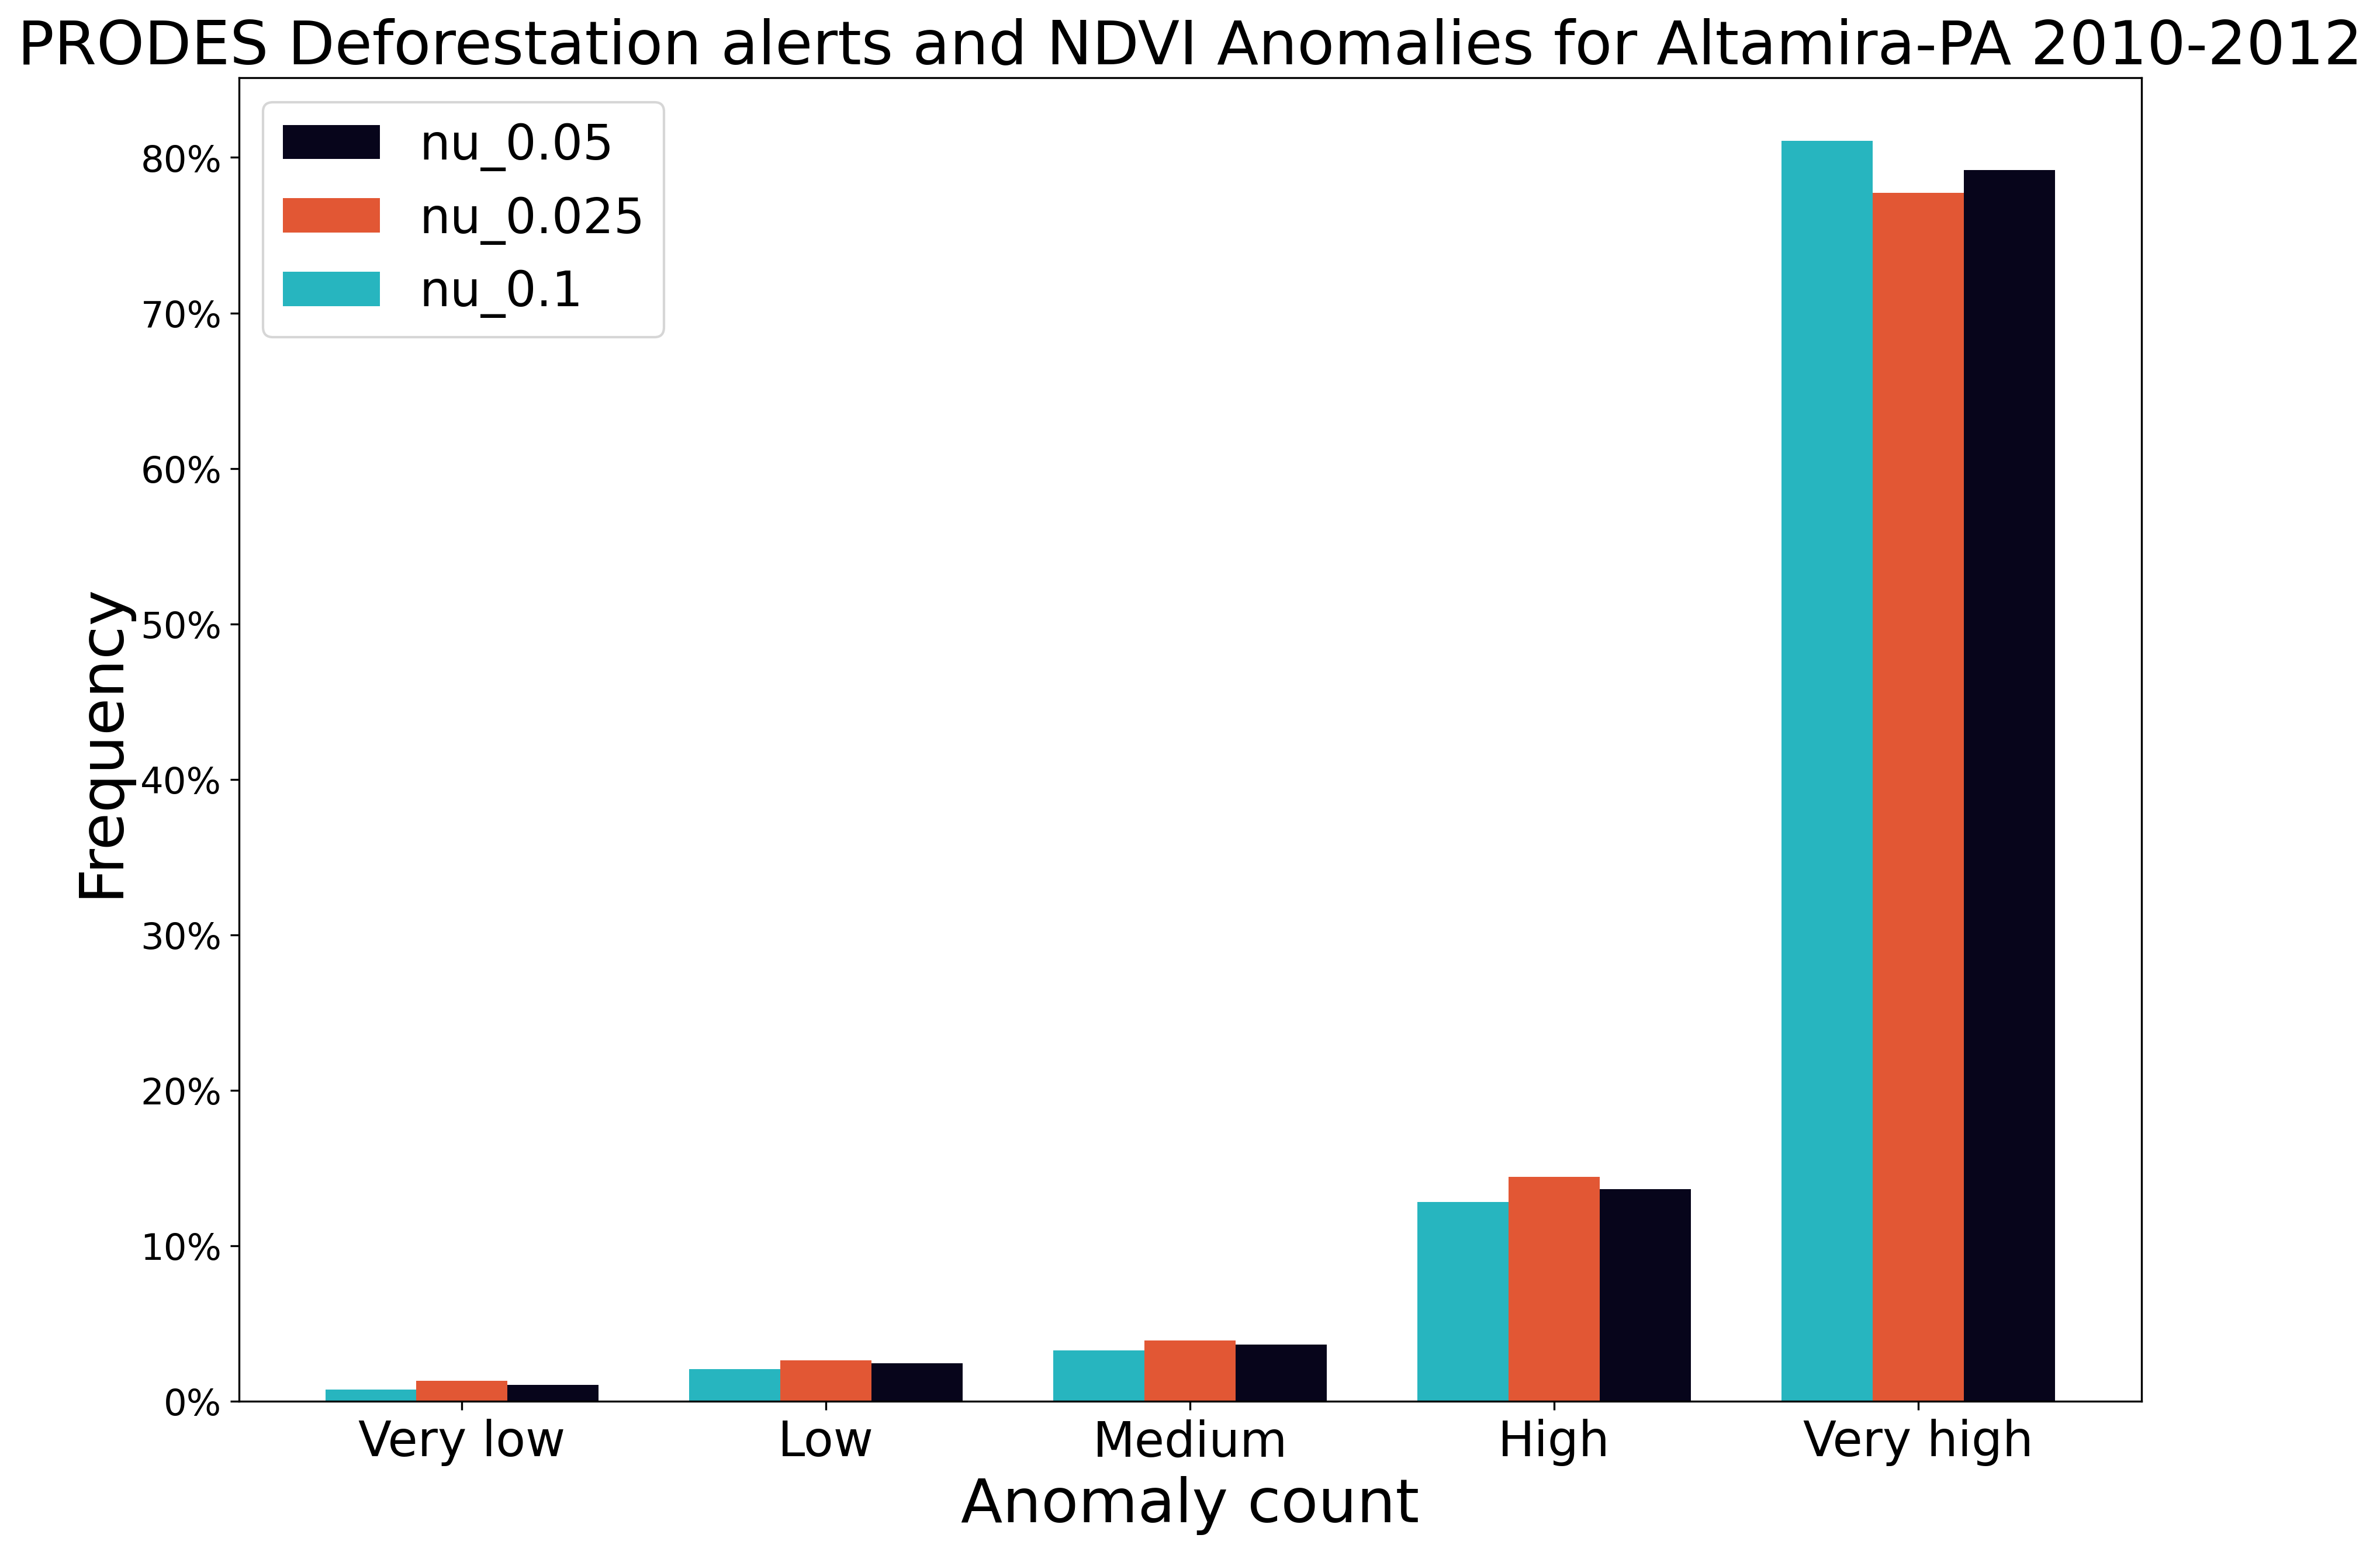

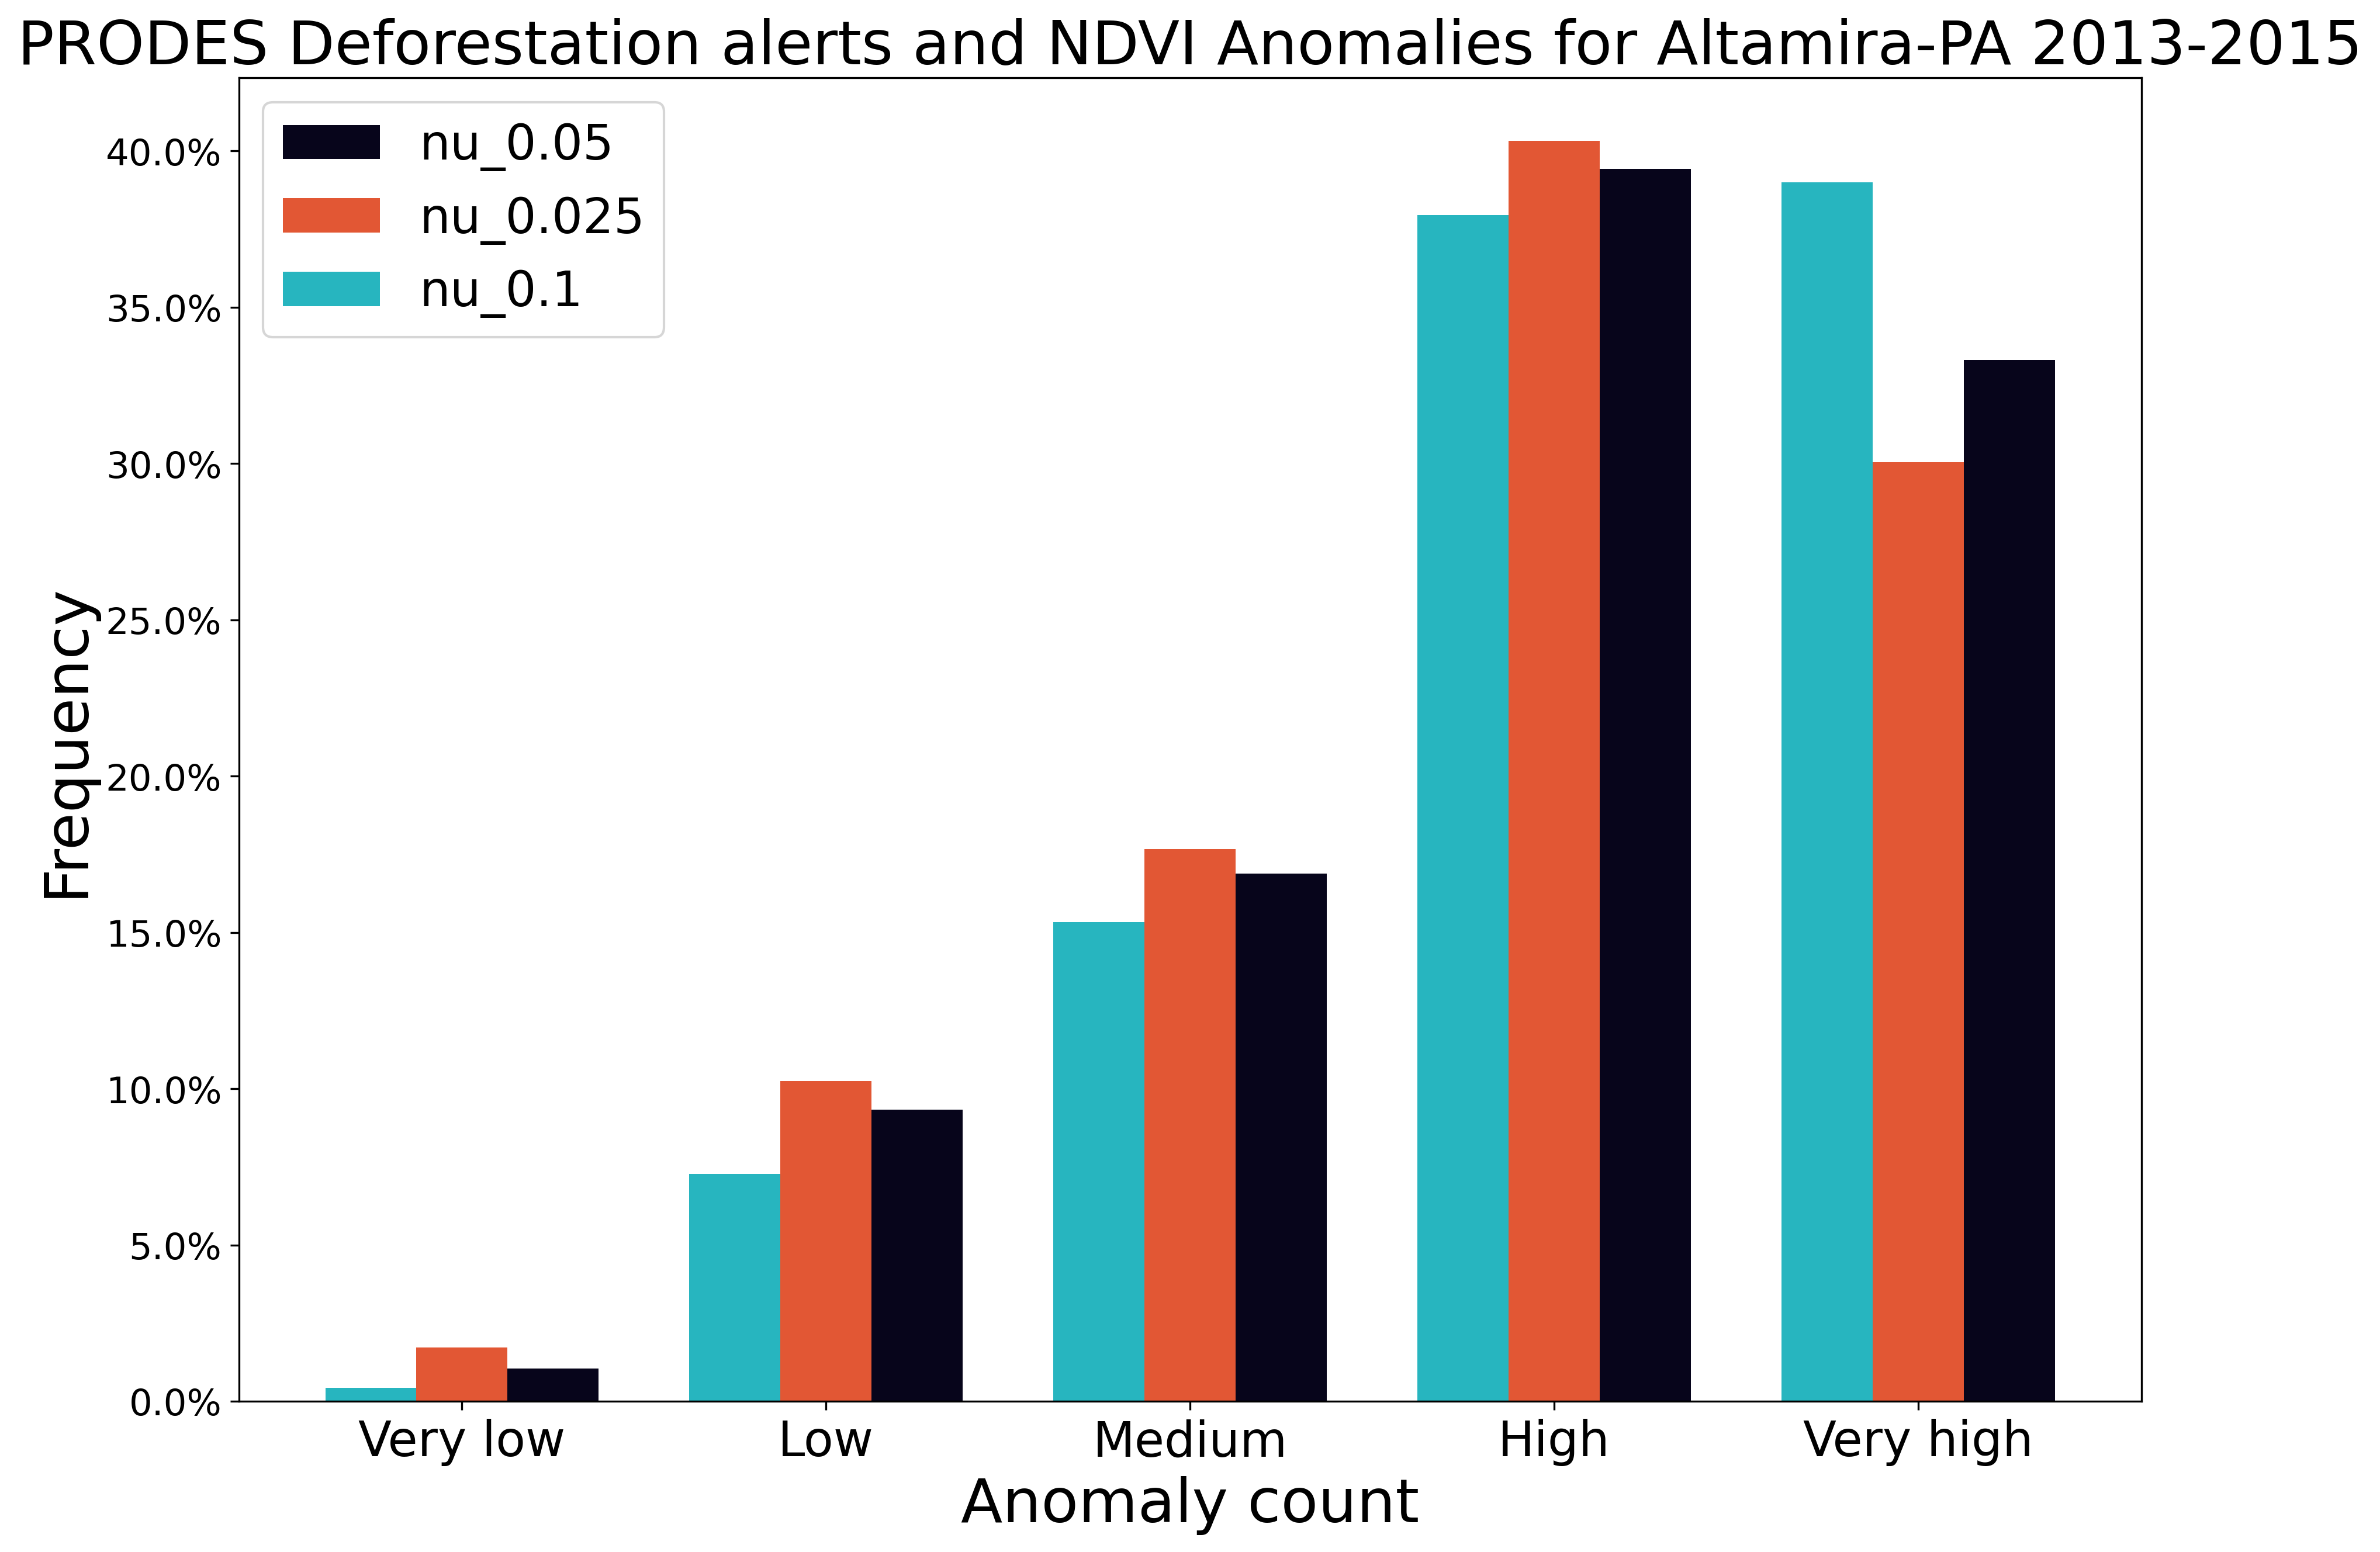

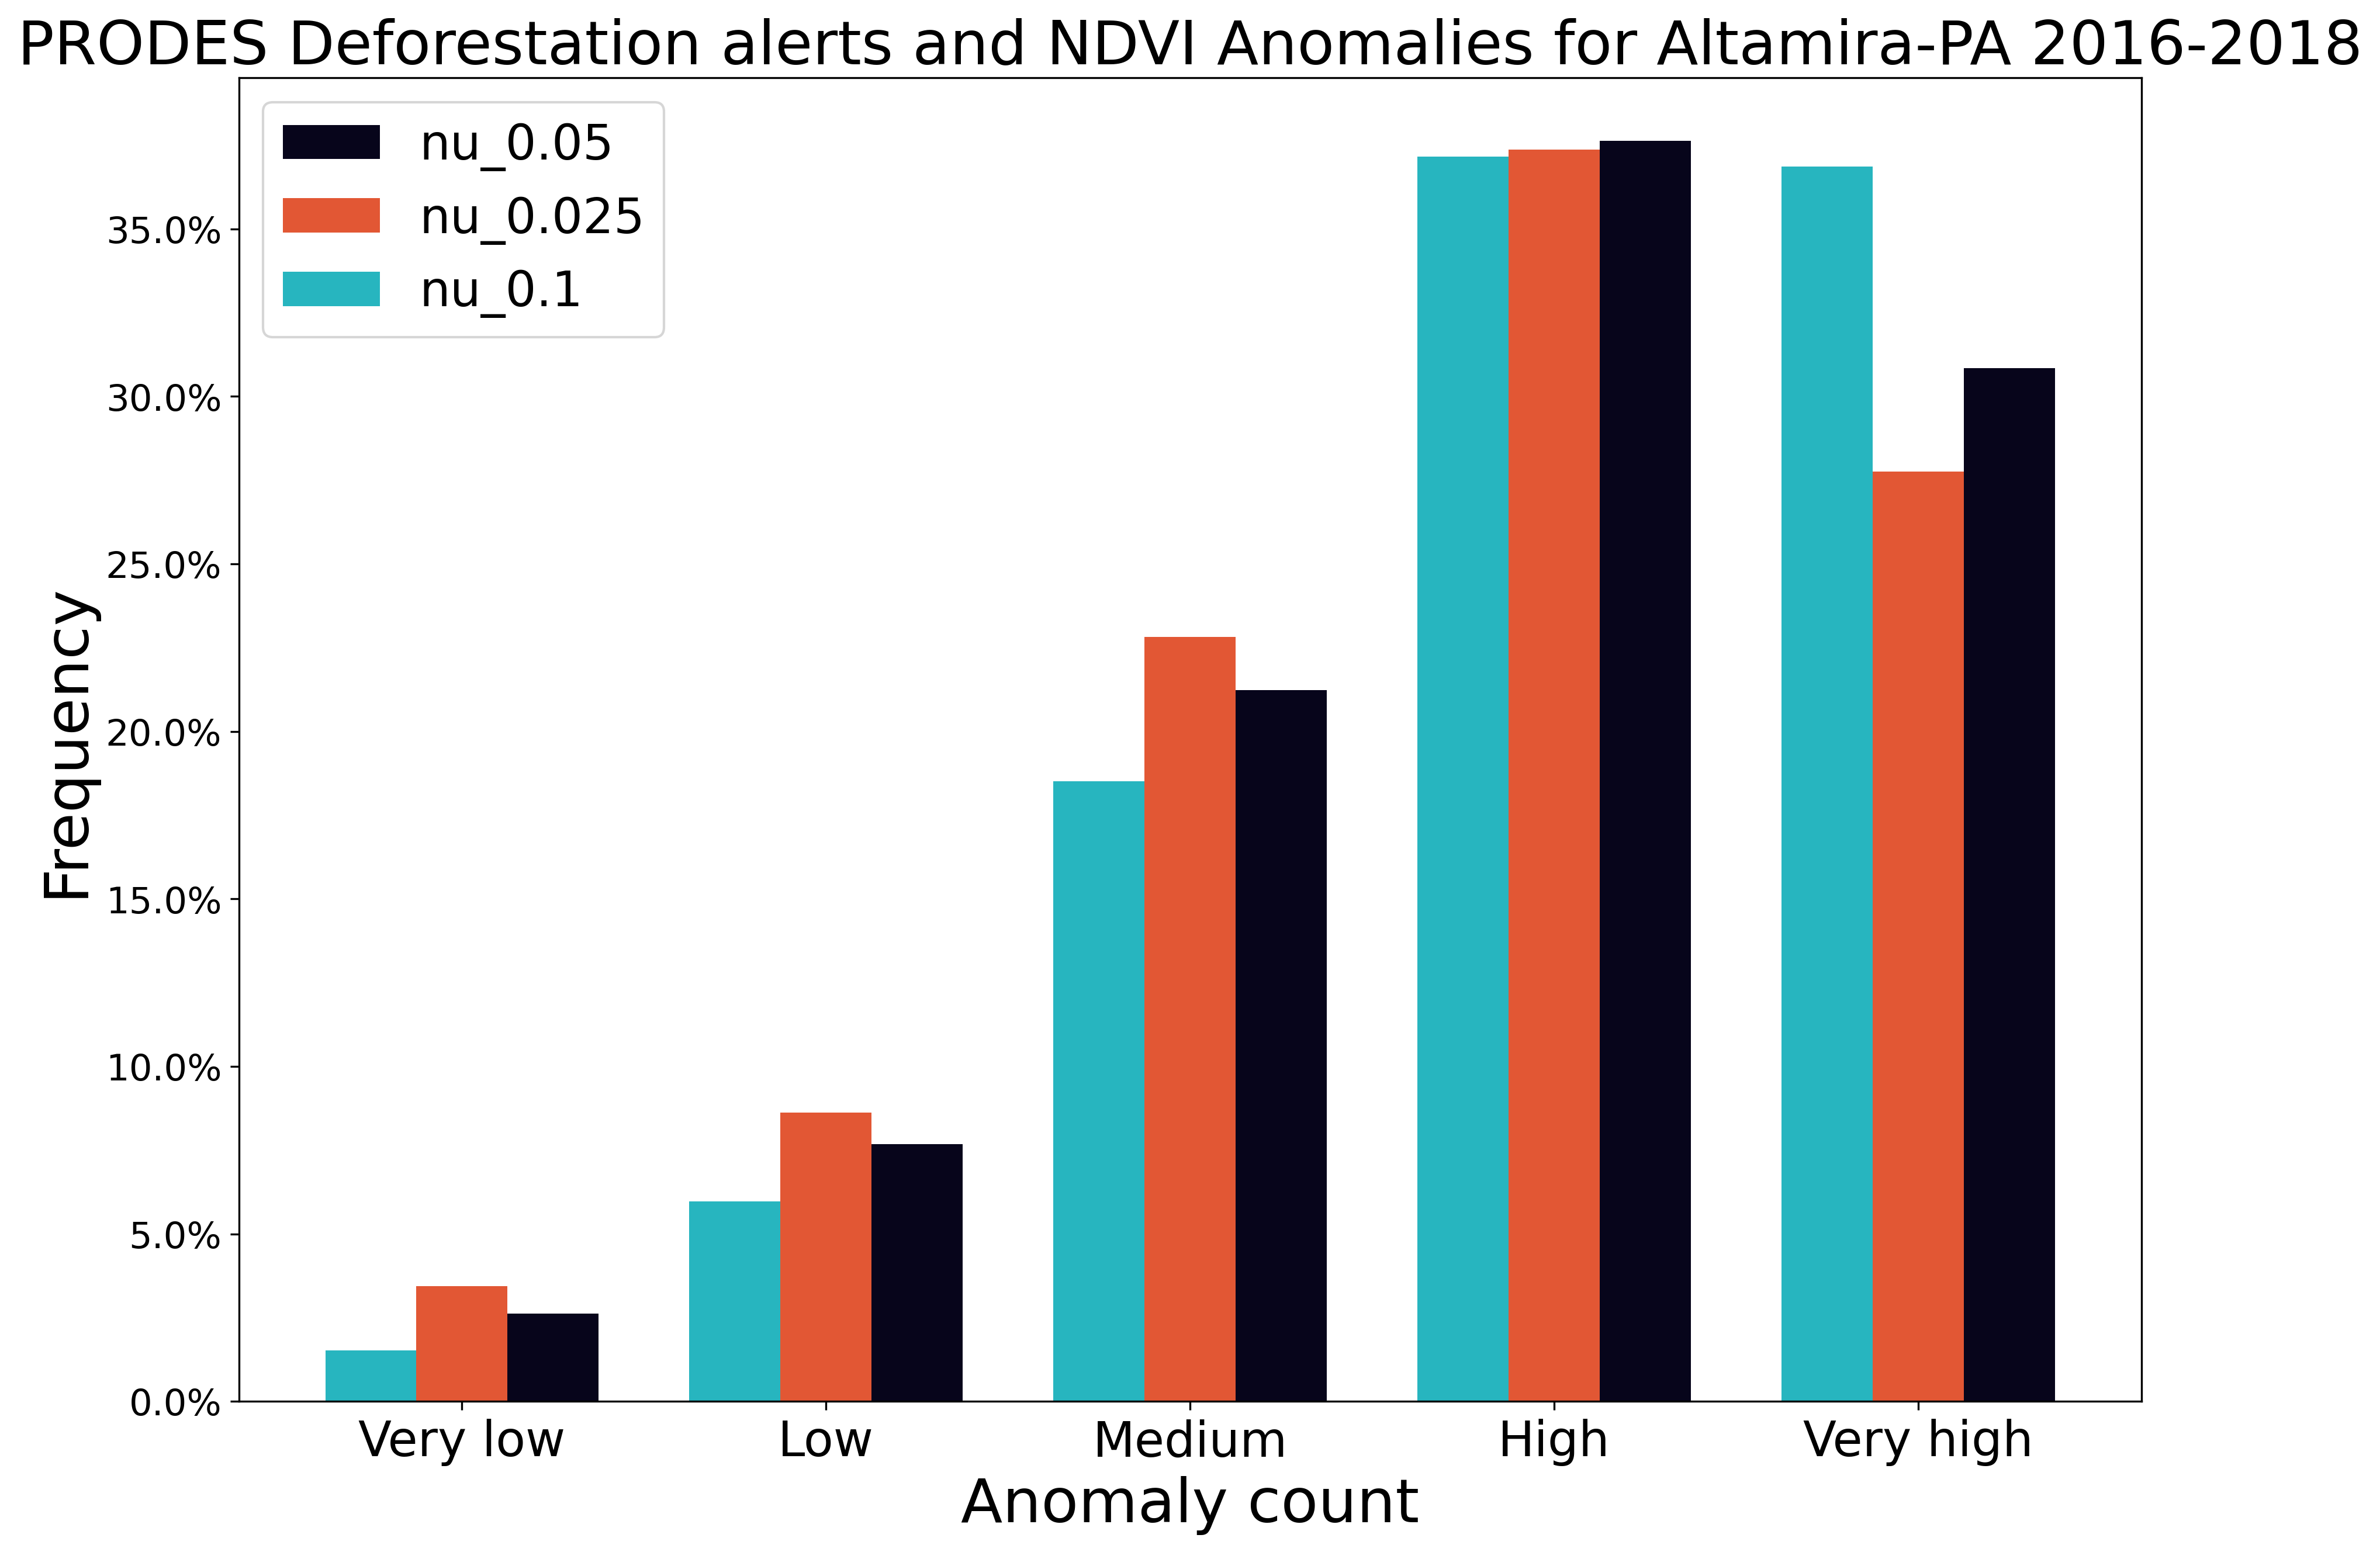

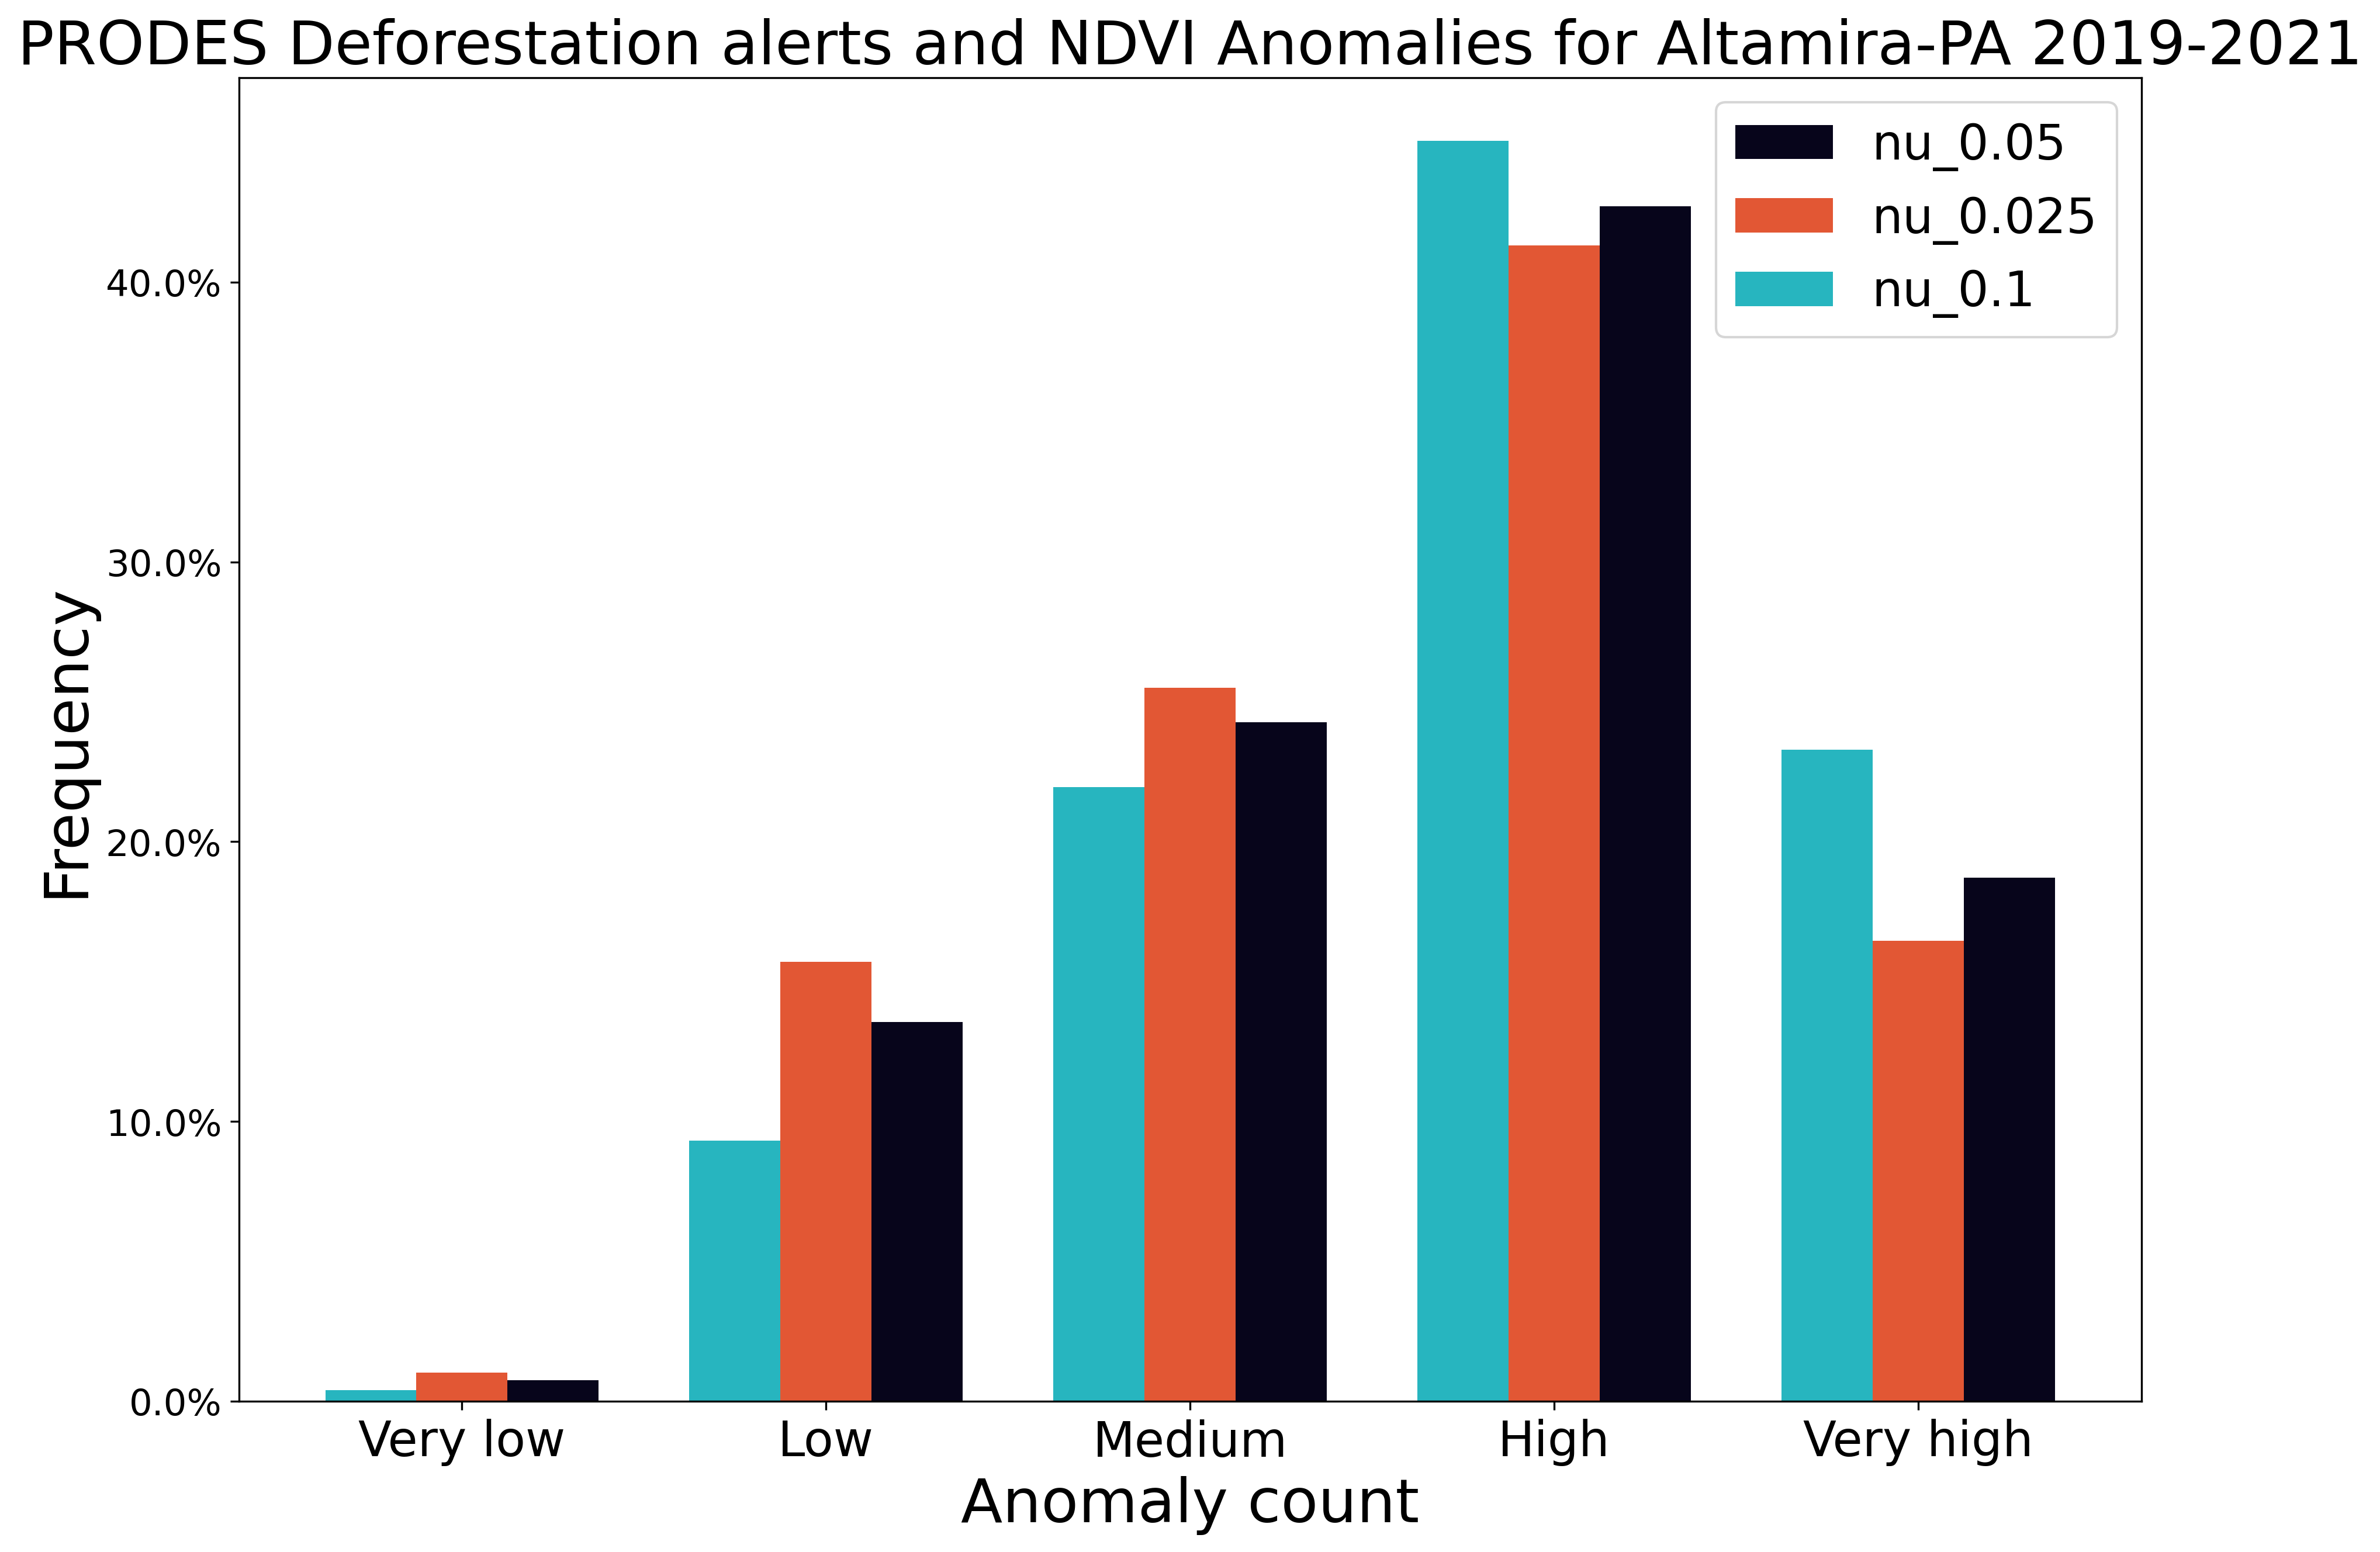

In [17]:
chavinho = list(dict_nu2['nu_0.025'].keys())
for t, z in zip(chavinho, chavao):
    dfnu1 = gera_data(dict_shp_path[z],dict_nu2['nu_0.025'][t])
    dfnu2 = gera_data(dict_shp_path[z],dict_nu2['nu_0.05'][t])
    dfnu3 = gera_data(dict_shp_path[z],dict_nu2['nu_0.1'][t])
    histo_gerav2(dfnu1, dfnu2, dfnu3, t, 'nu_0.025', 'nu_0.05', 'nu_0.1')
    plt.show()

In [18]:
from sklearn.metrics import f1_score
def dff2(df1):
    df1.loc[:,'f1'] = df1["id"]
    df1.loc[df1["id"]<=2,'f1'] = 0
    copia = df1[df1.id != 3].reset_index(drop=True)
    valor = f1_score(copia['id'].values, copia['f1'].values, average='micro')
    return valor

In [19]:
from sklearn.metrics import f1_score
def dff1(df1):
    df1.loc[:,'f2'] = 1
    df1.loc[df1["id"]<=2,'f1'] = 0
    df1.loc[df1["id"]>=4,'f1'] = 1
    copia = df1[df1.id != 3].reset_index(drop=True)
    valor = f1_score(copia['f1'].values, copia['f2'].values)
    return valor

In [20]:
metrica = dff1(dfnu1)
print('F1-Score para OCSVM com nu = 0.025 é ', metrica)

F1-Score para OCSVM com nu = 0.025 é  0.873572820941242


In [21]:
metrica = dff1(dfnu2)
print('F1-Score para OCSVM com nu = 0.05 é ', metrica)

F1-Score para OCSVM com nu = 0.05 é  0.8957368244377307


In [22]:
metrica = dff1(dfnu3)
print('F1-Score para OCSVM com nu = 0.1 é ', metrica)

F1-Score para OCSVM com nu = 0.1 é  0.9336183052552175


In [23]:
data_f1_oc = pd.DataFrame(index=nus, columns=chavinho)
data_f1_oc

,2010-2012,2013-2015,2016-2018,2019-2021
nu_0.025,NaN,NaN,NaN,NaN
nu_0.05,NaN,NaN,NaN,NaN
nu_0.1,NaN,NaN,NaN,NaN


In [24]:
for t, z in zip(chavinho, chavao):
    for na in nus:
        dfnu1 = gera_data(dict_shp_path[z],dict_nu2[na][t])
        metrica = dff1(dfnu1)
        data_f1_oc.loc[na,t] = metrica
        
data_f1_oc

,2010-2012,2013-2015,2016-2018,2019-2021
nu_0.025,0.978923,0.92165,0.915303,0.873573
nu_0.05,0.981383,0.93338,0.930053,0.895737
nu_0.1,0.985153,0.952263,0.951945,0.933618


In [25]:
data_f1_oc_v2 = pd.DataFrame(index=chavinho, columns=nus)
for t, z in zip(chavinho, chavao):
    for na in nus:
        dfnu1 = gera_data(dict_shp_path[z],dict_nu2[na][t])
        metrica = dff2(dfnu1)
        data_f1_oc_v2.loc[t,na] = metrica
    
data_f1_oc_v2

,nu_0.025,nu_0.05,nu_0.1
2010-2012,0.958716,0.963446,0.970741
2013-2015,0.854686,0.875082,0.908877
2016-2018,0.843833,0.869252,0.908296
2019-2021,0.775525,0.811162,0.875501


<AxesSubplot:title={'center':'f1 score by period and OCSVM contamination'}, xlabel='year', ylabel='f1 score'>

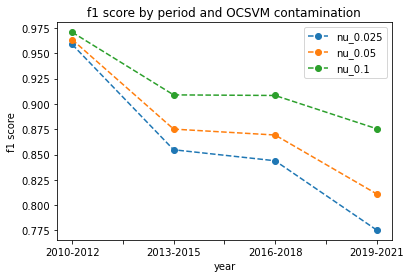

In [26]:
data_f1_oc_v2.plot(title='f1 score by period and OCSVM contamination', xlabel='year', ylabel='f1 score',linestyle='--', marker='o')

In [27]:
data_f1_oc_v2.to_csv('../../Altamira/csv/f1_score_ocsvm_periods.csv')

### Isolation Forest

In [39]:
dict_tif_path_if = {}
cont = 0
path = "../../Altamira/Tiff/V3/IF/Valida/"
dict_nu_if = {}
for x in os.listdir(path):
    if x.endswith(".tif"):
        ano = x[-13:-4]
        nuu = x[13:-14]
        if ano in chavinho:
            dict_tif_path_if[ano] = path + x
            dict_nu_if[nuu] = dict_tif_path_if

#dict_nu_if

In [40]:
path = "../../Altamira/Tiff/V3/IF/Valida/"
list_nu = []
for x in os.listdir(path):
    if x.endswith(".tif"):
        list_nu.append(x)
        
#list_nu

In [41]:
nus2 = list(dict_nu_if.keys())
cont=0
dict_nu2_if = {}
dict_tif_path_if = {}
for i in nus2:
    dict_tif_path_if = {}
    for x in list_nu[cont:cont+4]:
        ano = x[-13:-4]
        dict_tif_path_if[ano] = path + x
        dict_nu2_if[i] = dict_tif_path_if
    cont = cont + 4
    
dict_nu2_if

{'100_Estimators': {'2010-2012': '../../Altamira/Tiff/V3/IF/Valida/Alt_if_modis_100_Estimators_2010-2012.tif',
  '2013-2015': '../../Altamira/Tiff/V3/IF/Valida/Alt_if_modis_100_Estimators_2013-2015.tif',
  '2016-2018': '../../Altamira/Tiff/V3/IF/Valida/Alt_if_modis_100_Estimators_2016-2018.tif',
  '2019-2021': '../../Altamira/Tiff/V3/IF/Valida/Alt_if_modis_100_Estimators_2019-2021.tif'},
 '20_Estimators': {'2010-2012': '../../Altamira/Tiff/V3/IF/Valida/Alt_if_modis_20_Estimators_2010-2012.tif',
  '2013-2015': '../../Altamira/Tiff/V3/IF/Valida/Alt_if_modis_20_Estimators_2013-2015.tif',
  '2016-2018': '../../Altamira/Tiff/V3/IF/Valida/Alt_if_modis_20_Estimators_2016-2018.tif',
  '2019-2021': '../../Altamira/Tiff/V3/IF/Valida/Alt_if_modis_20_Estimators_2019-2021.tif'},
 '40_Estimators': {'2010-2012': '../../Altamira/Tiff/V3/IF/Valida/Alt_if_modis_40_Estimators_2010-2012.tif',
  '2013-2015': '../../Altamira/Tiff/V3/IF/Valida/Alt_if_modis_40_Estimators_2013-2015.tif',
  '2016-2018': '../../

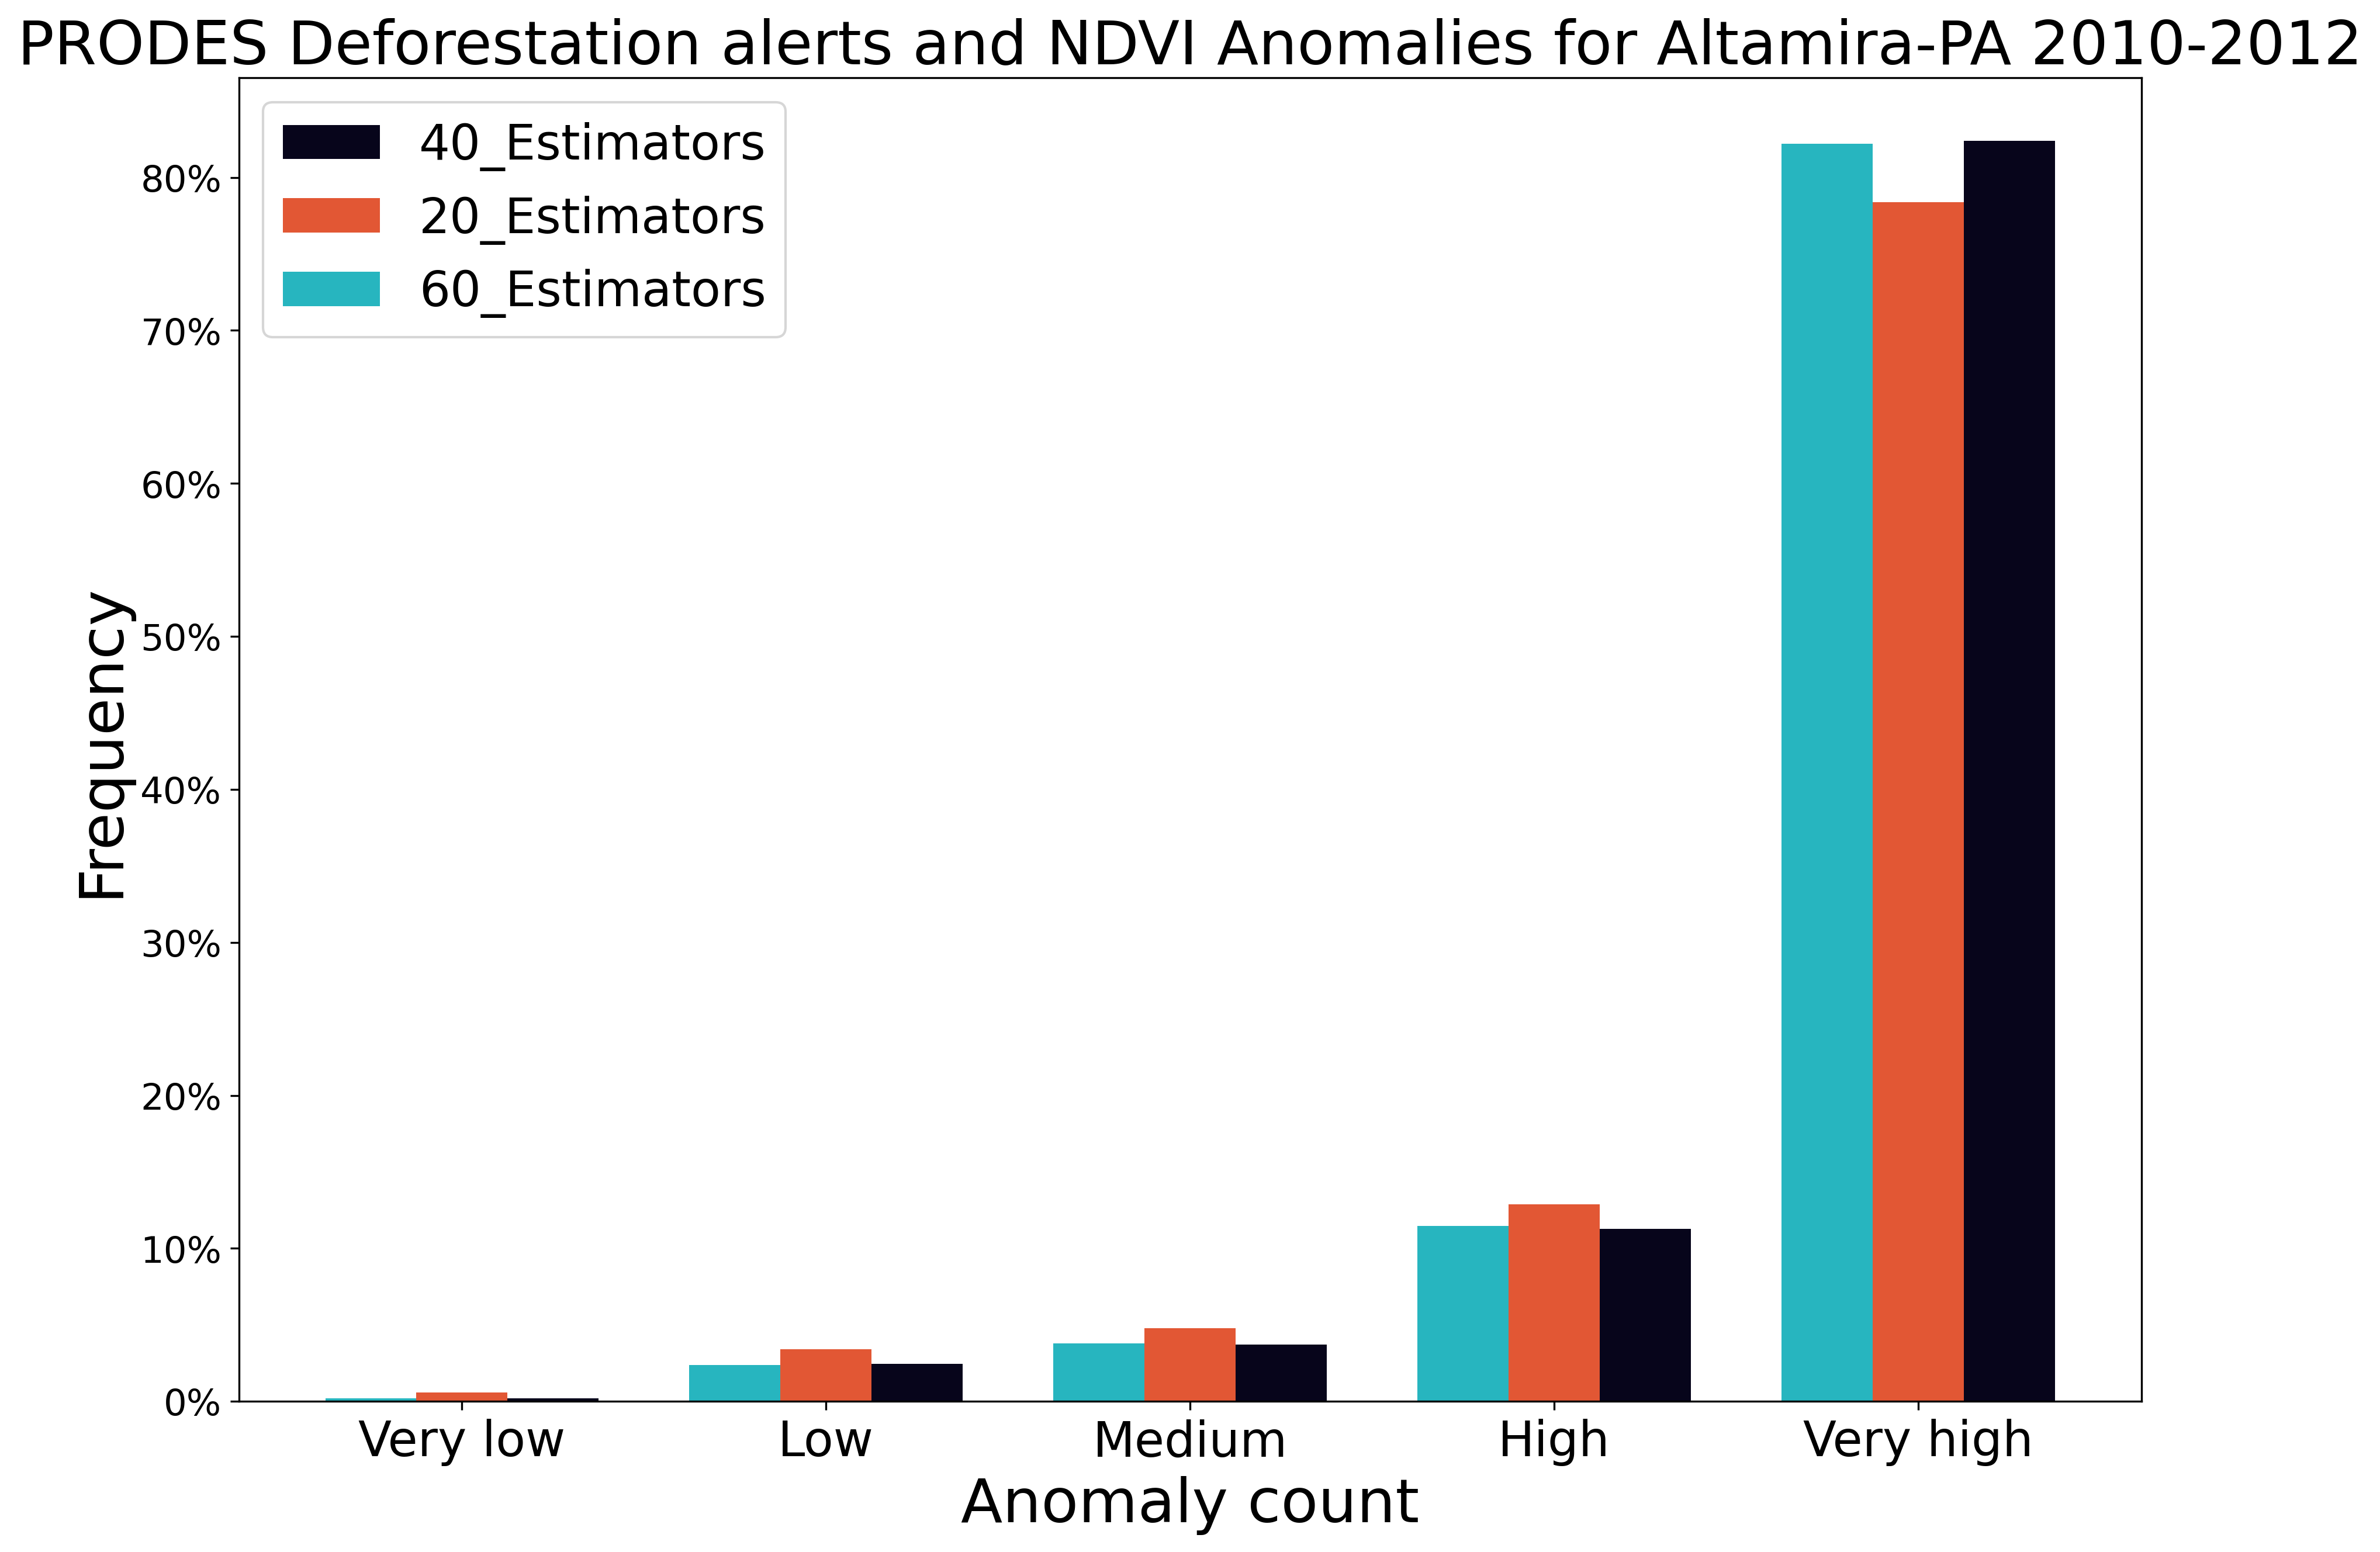

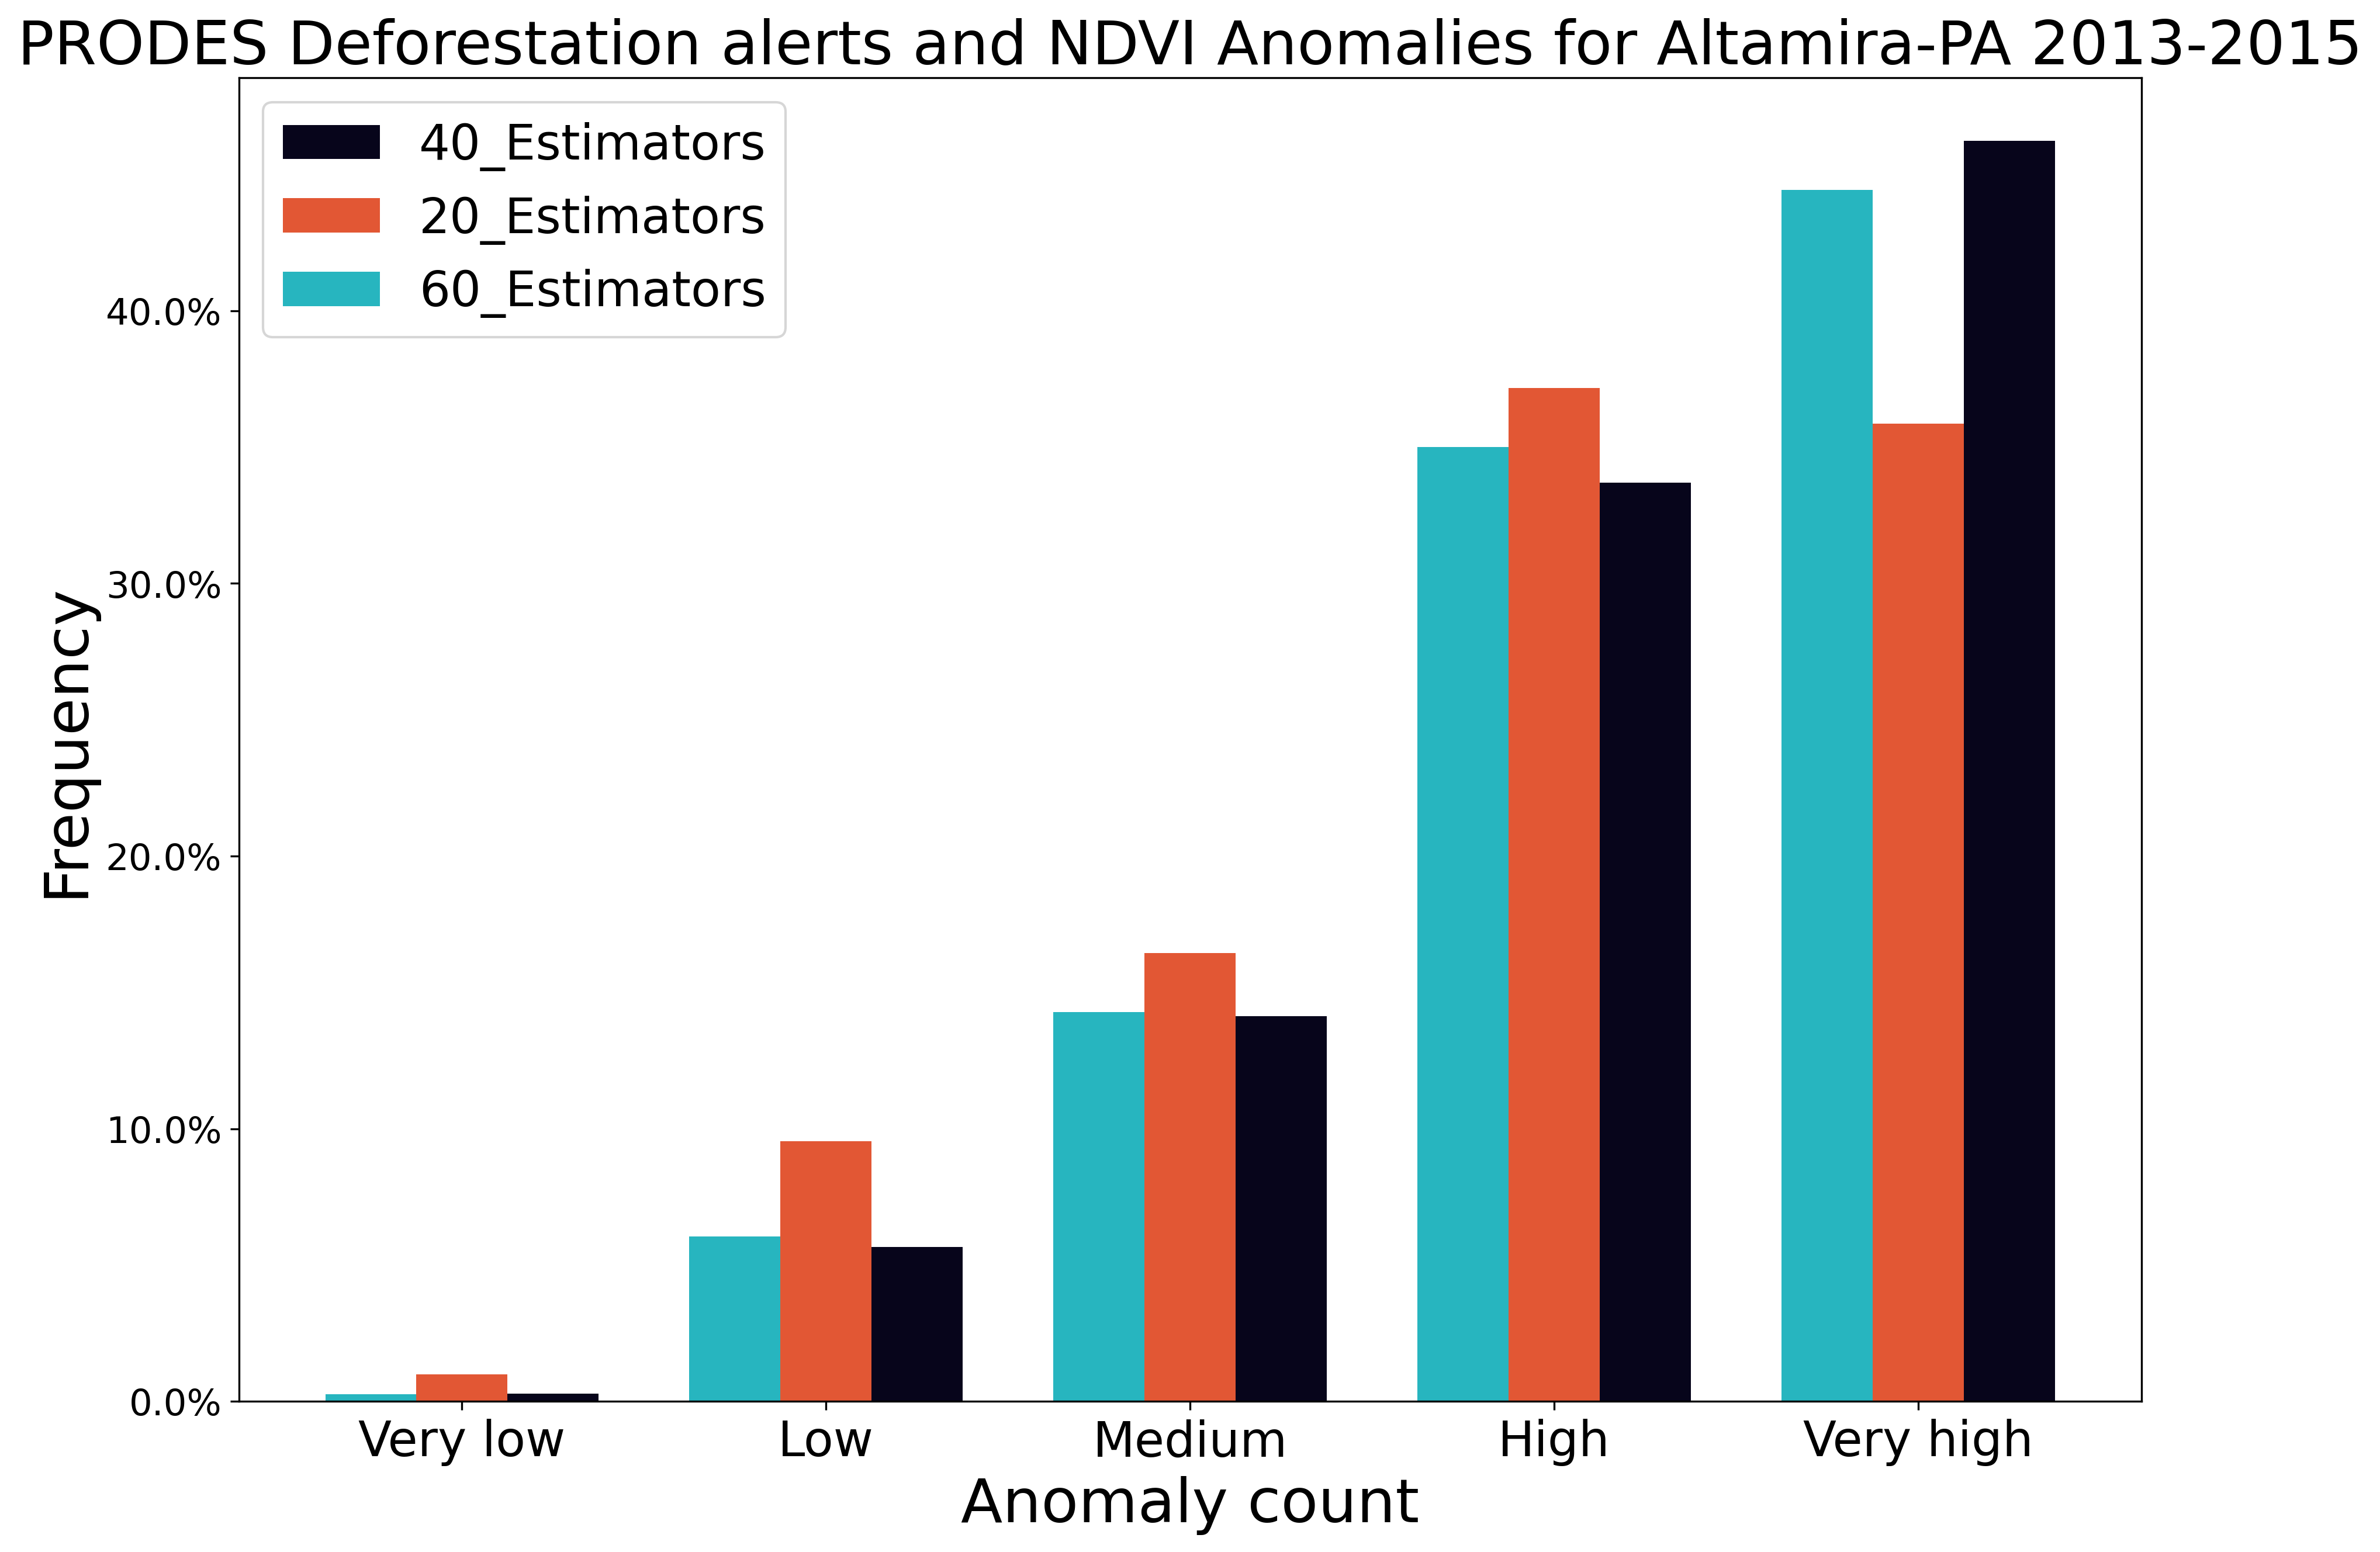

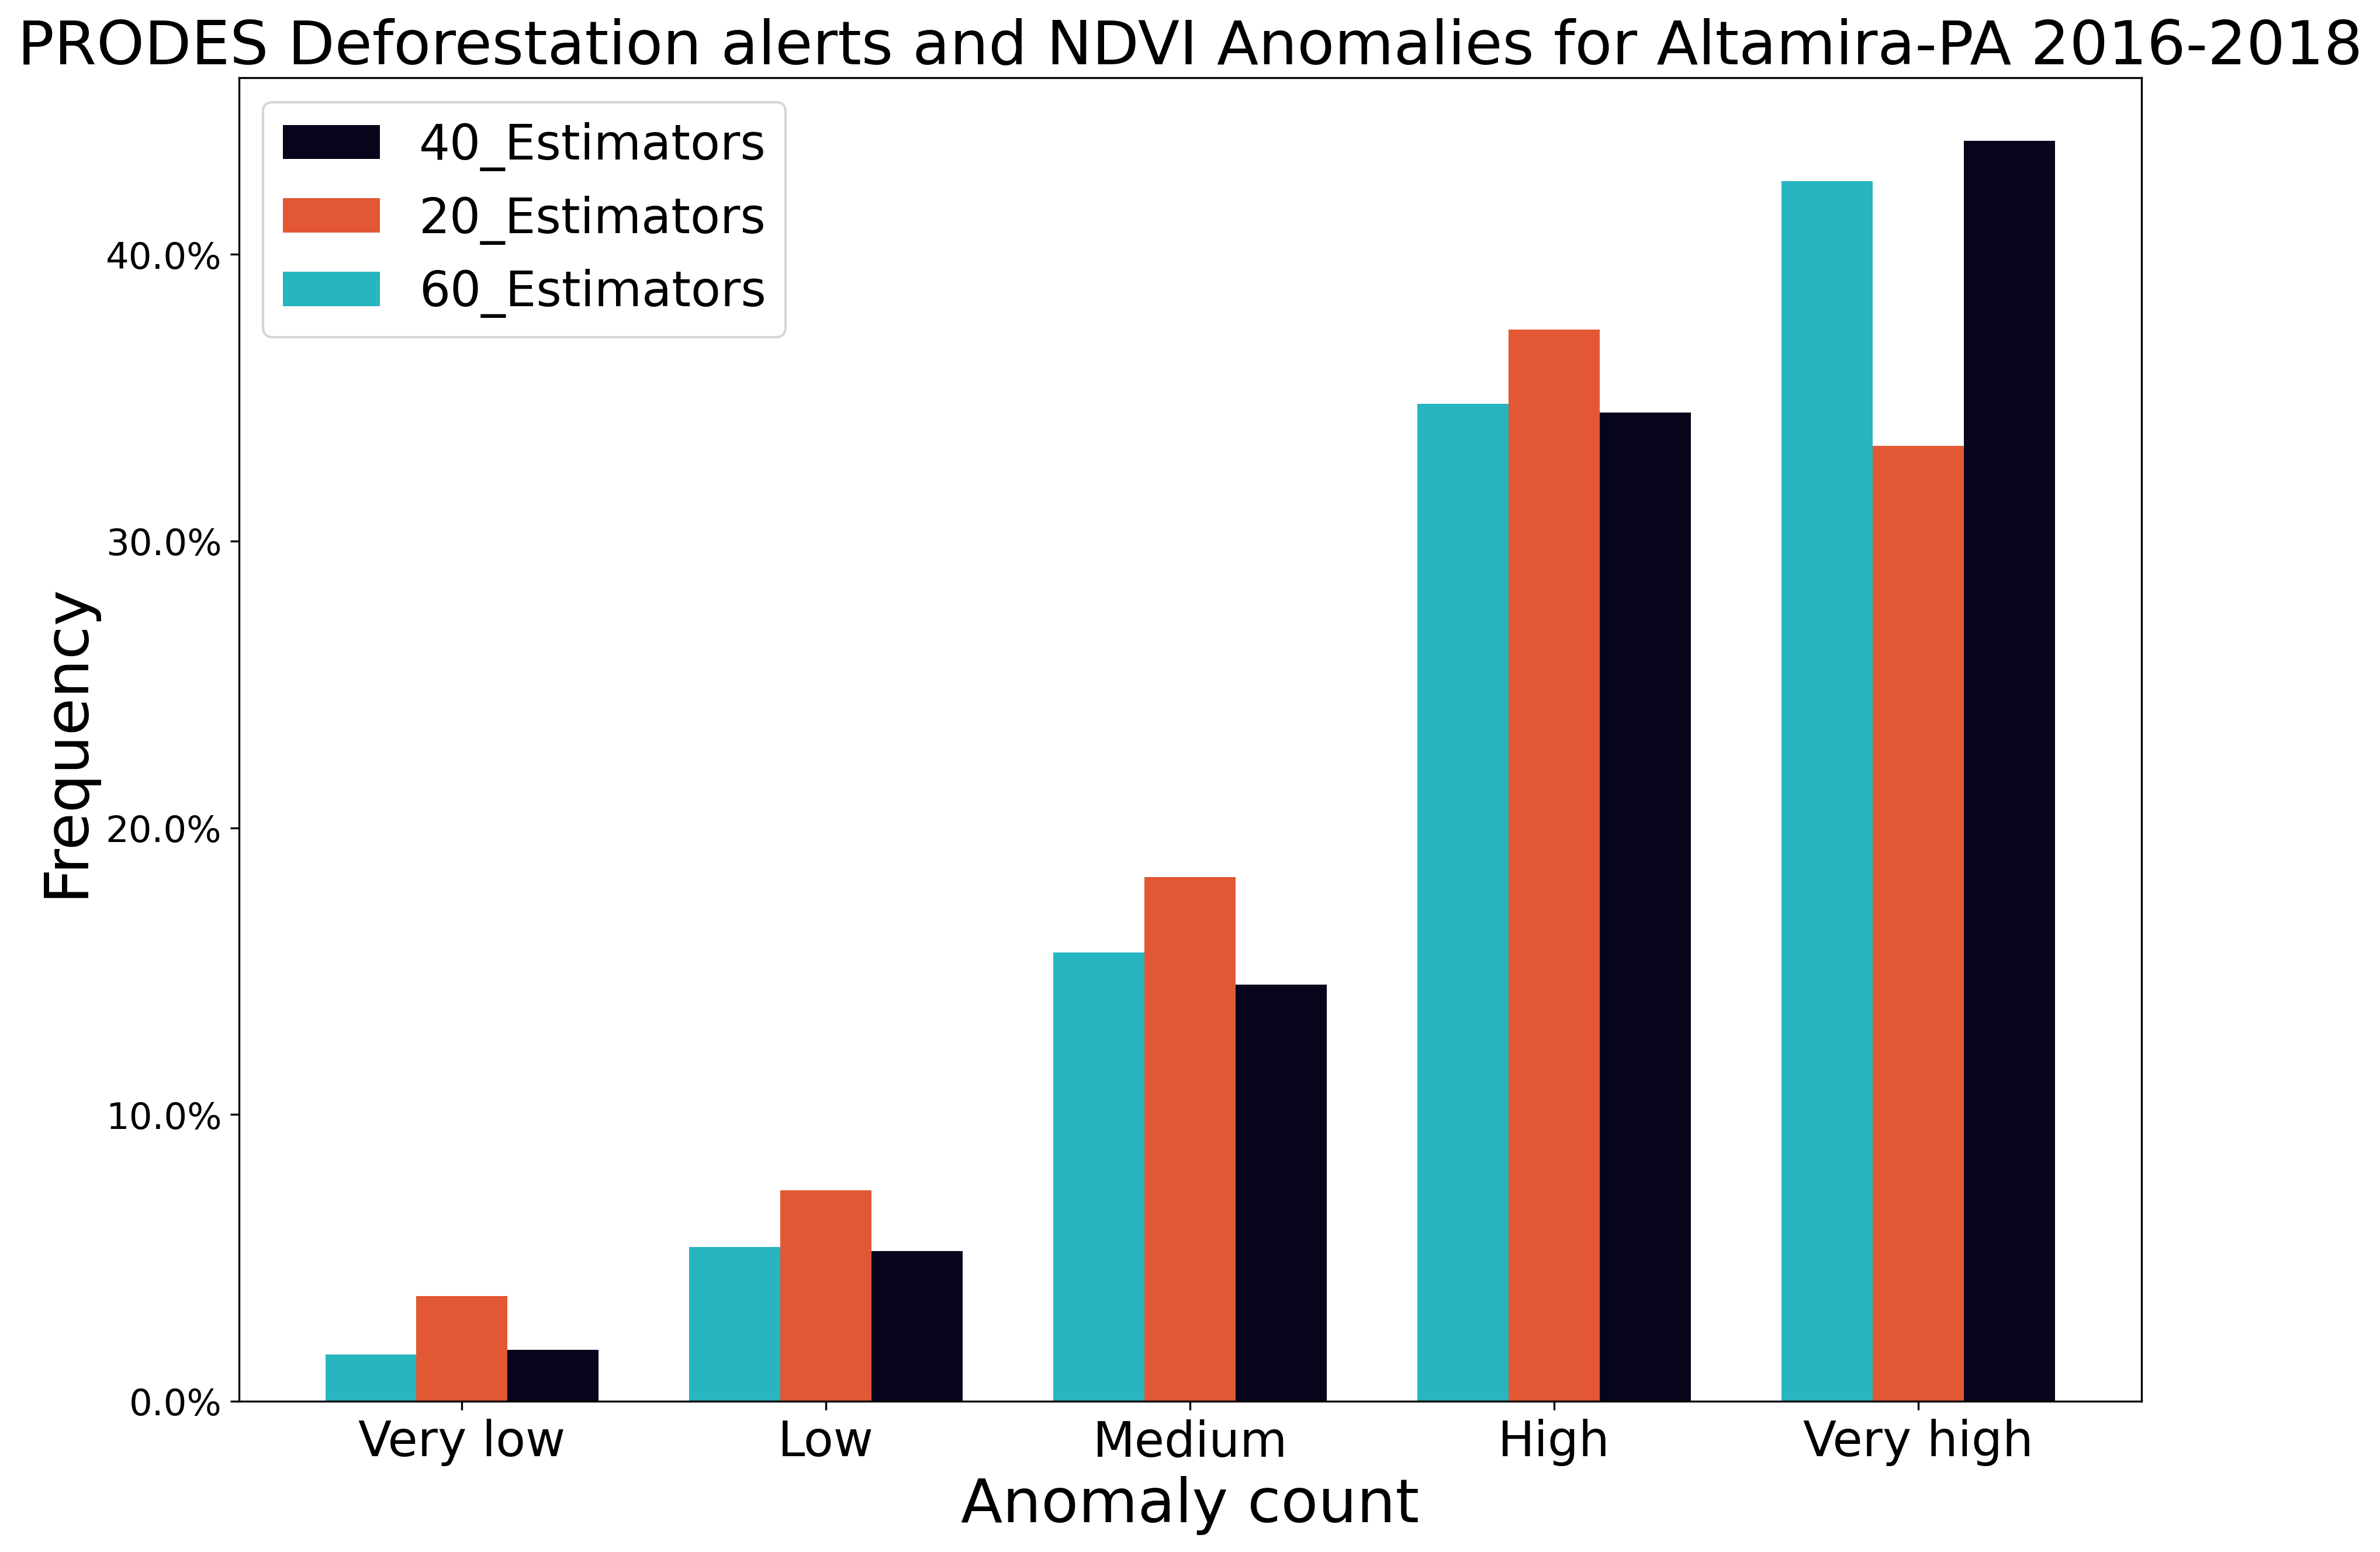

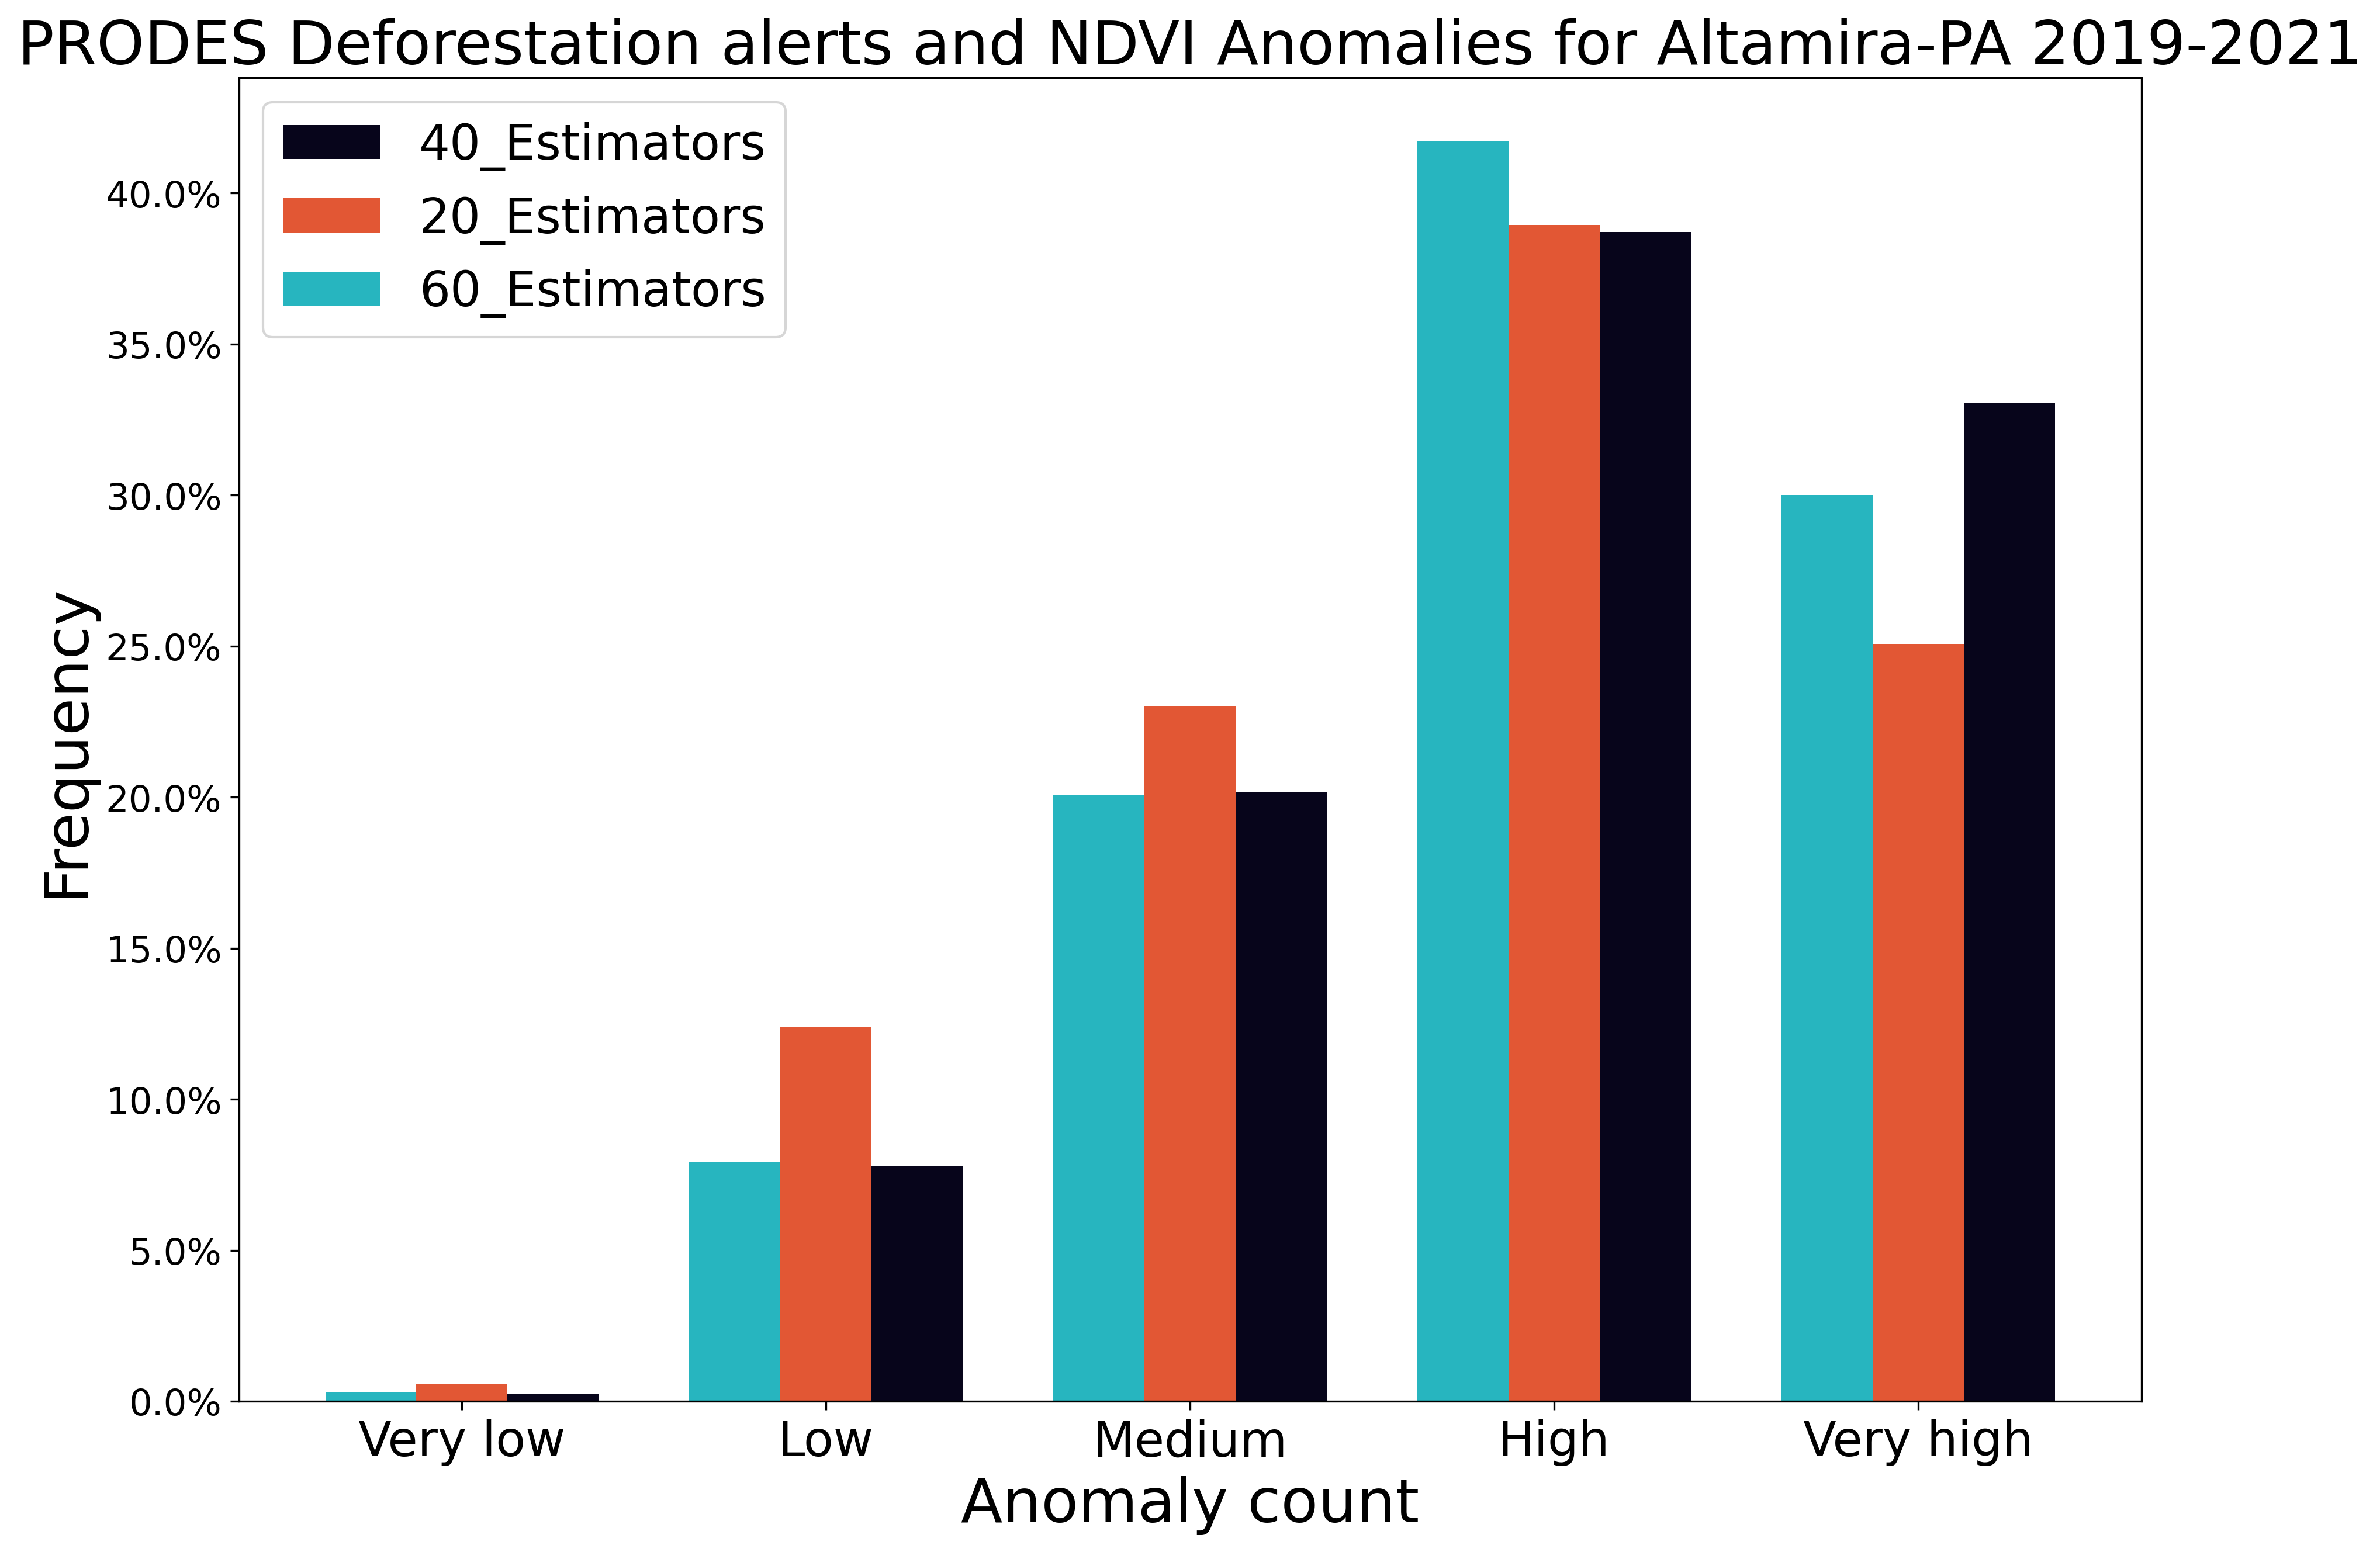

In [42]:
chavinho = list(dict_nu2_if['100_Estimators'].keys())
for t, z in zip(chavinho, chavao):
    dfnu1 = gera_data(dict_shp_path[z],dict_nu2_if['20_Estimators'][t])
    dfnu2 = gera_data(dict_shp_path[z],dict_nu2_if['40_Estimators'][t])
    dfnu3 = gera_data(dict_shp_path[z],dict_nu2_if['60_Estimators'][t])
    histo_gerav2(dfnu1, dfnu2, dfnu3, t, '20_Estimators', '40_Estimators', '60_Estimators')
    plt.show()

In [47]:
nus3 = ["20_Estimators", "40_Estimators", "60_Estimators"]
data_f1_if_v2 = pd.DataFrame()
for t, z in zip(chavinho, chavao):
    for na in nus3:
        dfnu1 = gera_data(dict_shp_path[z],dict_nu2_if[na][t])
        metrica = dff2(dfnu1)
        data_f1_if_v2.loc[t,na] = metrica
    
data_f1_if_v2

,20_Estimators,40_Estimators,60_Estimators
2010-2012,0.958388,0.972567,0.973203
2013-2015,0.873778,0.930670,0.926530
2016-2018,0.865183,0.917815,0.916911
2019-2021,0.831461,0.899251,0.897318


<AxesSubplot:title={'center':'f1 score by period and Isolation Forest contamination'}, xlabel='year', ylabel='f1 score'>

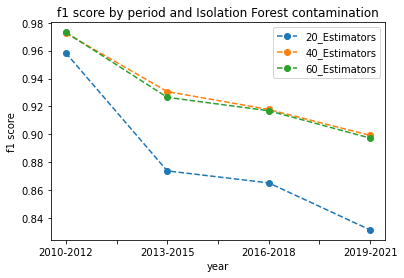

In [48]:
data_f1_if_v2.plot(title='f1 score by period and Isolation Forest contamination', xlabel='year', ylabel='f1 score',linestyle='--', marker='o')

In [50]:
data_f1_if_v2.to_csv('../../Altamira/csv/f1_score_if_periods.csv')

<AxesSubplot:title={'center':'f1 score by period and OCSVM contamination'}, xlabel='year', ylabel='f1 score'>

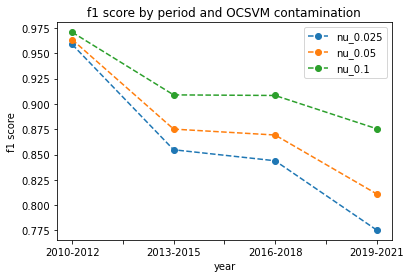

In [49]:
data_f1_oc_v2.plot(title='f1 score by period and OCSVM contamination', xlabel='year', ylabel='f1 score',linestyle='--', marker='o')